Simulaciones de base, utilizando la modalidad fija, para comparación con métodos de redes neuronales en la predicción de precio de criptomonedas.

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Keras
from math import sqrt
from sklearn.metrics import mean_squared_error

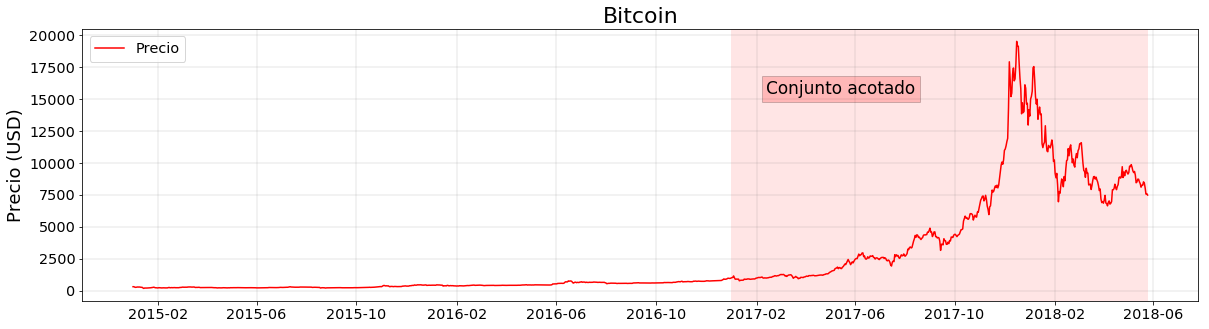

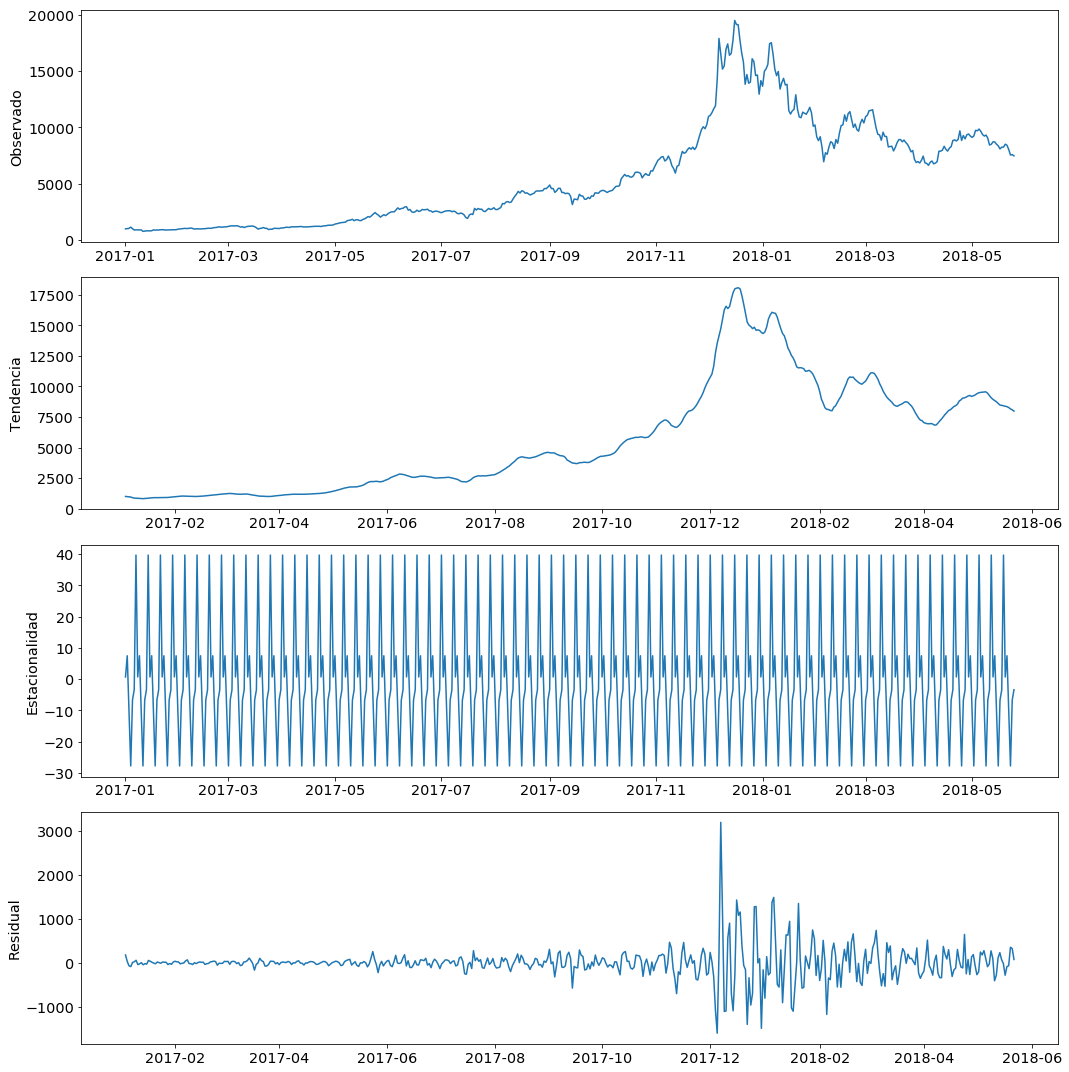

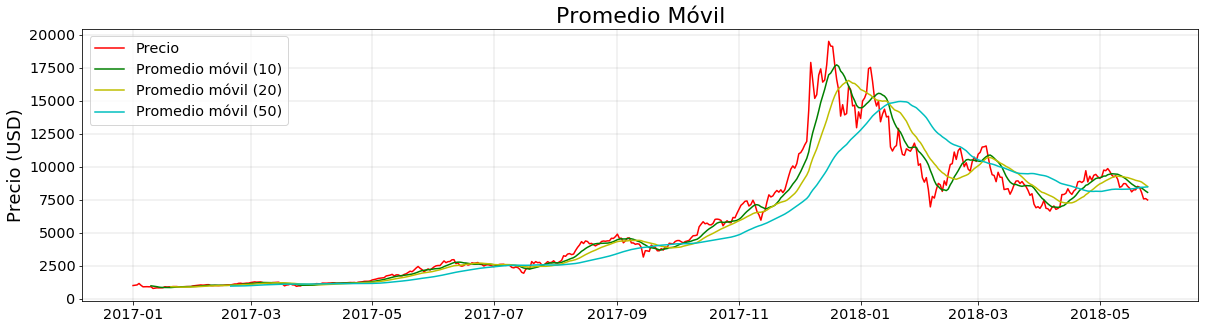

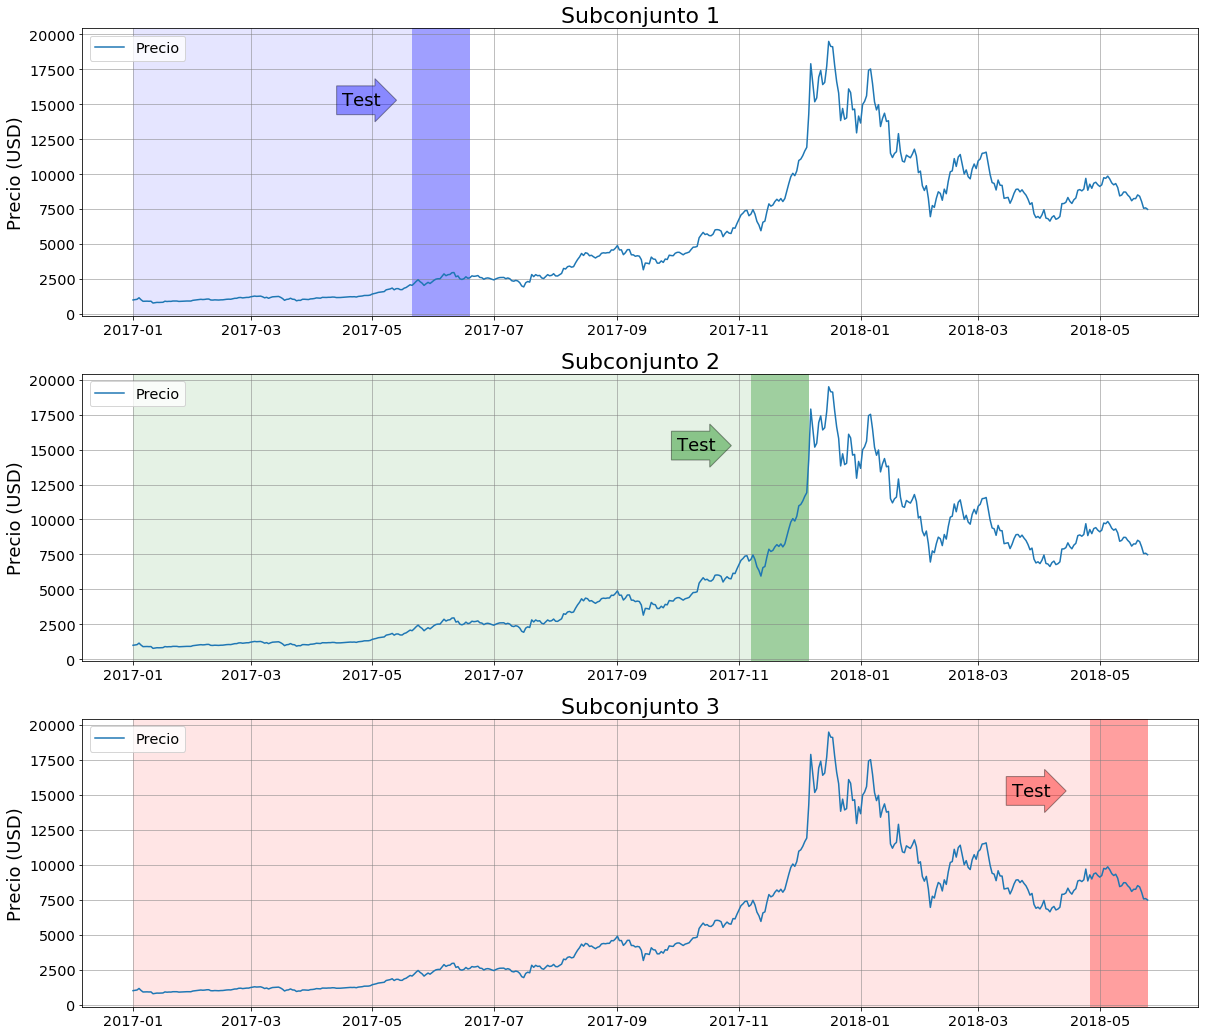

In [2]:
data = pd.read_csv('data/data.csv', usecols=['Date','Close bitcoin'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

#Simulaciones
test_size = 30
moneda = 'bitcoin'
target = 'Close bitcoin'
N_tests = 3 #Cuantos tests se van a hacer con la serie
colores_test = ['r','g','b','c']
colores_futuro = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# Visualización de la serie completa
fig = plt.figure(figsize=(20,5))
plt.plot(data, color = 'r', label="Precio")
plt.axvspan('2017-01-01', data.index[-1], facecolor='r', alpha=0.1)
fig.text(0.6, 0.7, 'Conjunto acotado', fontsize=17, bbox=dict(facecolor='red', alpha=0.2))
plt.ylabel('Precio (USD)', fontsize=18)
plt.legend(loc='upper left')
plt.title("Bitcoin",fontsize=22)
plt.grid(color='grey', linestyle='-', linewidth=0.2)

# Se acota el conjunto de datos para un período significativo
data = data['2017-01-01':'2018-05-25']

# Descomposición de la serie en componentes 
res = sm.tsa.seasonal_decompose(data,model='additive')
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(15,15))
axes[0].plot(res.observed);axes[0].set_ylabel('Observado')
axes[1].plot(res.trend);axes[1].set_ylabel('Tendencia')
axes[2].plot(res.seasonal);axes[2].set_ylabel('Estacionalidad')
axes[3].plot(res.resid);axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.savefig('data/descomposicion.png')
plt.show()

# Visualización del promedio móvil para 10, 20 y 50 días
promedio_movil_10 = data.rolling(window=10).mean()
promedio_movil_20 = data.rolling(window=20).mean()
promedio_movil_50 = data.rolling(window=50).mean()
fig = plt.figure(figsize=(20,5))
plt.plot(data, color = 'r', label="Precio")
plt.plot(promedio_movil_10, color='g', label="Promedio móvil (10)")
plt.plot(promedio_movil_20, color='y', label="Promedio móvil (20)")
plt.plot(promedio_movil_50, color='c', label="Promedio móvil (50)")
plt.ylabel('Precio (USD)', fontsize=18)
plt.legend(loc='upper left')
plt.title("Promedio Móvil",fontsize=22)
plt.grid(color='grey', linestyle='-', linewidth=0.2)

# Visualización de separación en tres tests
fig = plt.figure(figsize=(20,6*N_tests))
gs = gridspec.GridSpec(N_tests, 1, wspace=0, hspace=0.2); i=0
for n_test in range(N_tests-1,-1,-1):
    end=None if n_test == 0 else n_test*(-200+test_size)
    subconjunto = data[:end]; subconjunto_test = subconjunto[-test_size:]
    ax = plt.subplot(gs[i, 0:])
    ax.plot(data.index, data[[target]], label="Precio")  
    plt.axvspan(subconjunto.index[0], subconjunto.index[-1], facecolor=colores_test[n_test], alpha=0.1)
    plt.axvspan(subconjunto_test.index[0], subconjunto_test.index[-1], facecolor=colores_test[n_test], alpha=0.3)
    ax.text(0.25+i*0.3, 0.75, "Test", ha="center", va="center", size=18,transform=ax.transAxes, bbox= dict(boxstyle="rarrow,pad=0.3", fc=colores_test[n_test], alpha=0.4))
    plt.ylabel('Precio (USD)', fontsize=18)
    plt.title("Subconjunto " + str(i+1),fontsize=22)
    plt.legend(loc='upper left')
    plt.grid(color='grey', linestyle='-', linewidth=0.5); i+=1
    plt.savefig('data/subconjuntos.png')

In [3]:
#Método para graficar las predicciones
def graficarBaselines(predicciones,nombre,parametro):
    fig = plt.figure(figsize=(25,10*4))
    gs = gridspec.GridSpec(5, 4, wspace=0.3, hspace=0.4)

    # Graficar la predicción completa (todos los subconjuntos de test)
    axPrediccionCompleta = plt.subplot(gs[0, 0:])
    axPrediccionCompleta.plot(predicciones.index, predicciones[predicciones.columns[0]], color='dimgray', label="Precio Real")  
    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
    plt.xticks(rotation=0, ha="center")
    axPrediccionCompleta.set_title("Predicciones - Método " + nombre, fontsize=22)
    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
    col=0
    for c in predicciones.columns[1:]:
        #Graficar cada prediccion
        axPrediccionCompleta.plot(predicciones.index, predicciones[c], label=c, color=colores_futuro[col % len(colores_futuro)])   
        col+=1
    axPrediccionCompleta.legend(loc='upper left')  

    # Graficar cada subconjunto de test
    i=1 #index de subplot
    rmses_y = []
    rmses_x = []
    prediccionxdataset = pd.DataFrame() # Dataframe con los tres tests, sin NaN
    for n_test in range(0,N_tests): 
        end = int((n_test+1)*len(predicciones)/N_tests)
        subprediccion = predicciones[0:end]
        subprediccion_test = subprediccion[-test_size:]
        prediccionxdataset = prediccionxdataset.append(subprediccion_test)
        
        #Colorear cada porcion de testing
        axPrediccionCompleta.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)  

        #Cada prediccion   
        axPrediccion = plt.subplot(gs[i, 1:])
        axPrediccion.plot(subprediccion[subprediccion.columns[0]].index[-45:], subprediccion[subprediccion.columns[0]][-45:], color='dimgray', label="Precio Real")
        axPrediccion.axvspan(subprediccion_test.index[0], subprediccion_test.index[-1], facecolor=colores_test[n_test], alpha=0.1)
        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
        plt.xticks(rotation=0, ha="center")
        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5) 

        rmses_y_subprediccion = []
        rmses_x_subprediccion = []
        col=0 #color de alfa
        for c in subprediccion_test.columns[1:]:
            axPrediccion.plot(subprediccion_test[c].index, subprediccion_test[c], label=c, color=colores_futuro[col % len(colores_futuro)]);col+=1

            rmse = sqrt(mean_squared_error(subprediccion_test[subprediccion_test.columns[0]], 
                                           subprediccion_test[c]))
            rmses_y_subprediccion.append(rmse)        
            rmses_y.append(rmse)
            rmses_x.append(c +' ('+ str(i) +')')  
            rmses_x_subprediccion.append(c +' ('+ str(i) +')')  

        axPrediccion.legend(loc='upper left')

        #RMSE
        width = 1/1.5
        barplot = plt.subplot(gs[i, 0])
        barplot = plt.bar(rmses_x_subprediccion, rmses_y_subprediccion, width)
        col = 0
        for rect in barplot: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=17, rotation=90, ha='center',va='bottom')
            rect.set_color(colores_futuro[col % len(colores_futuro)]); col+=1
        plt.xticks(rotation=60, ha="right")
        plt.ylim(ymax=max(rmses_y_subprediccion)*1.2)
        plt.title("RMSE por " + parametro, fontsize=22)

        i+=1
    '''        
    #Graficar todos los RMSE
    width = 1/1.5
    barplot = plt.subplot(gs[i, 0:3 ])
    bars = plt.bar(rmses_x, rmses_y, width)
    for n_test in range(0,N_tests):
        col = 0;
        for rect in bars[n_test*len(predicciones.columns[1:]) : (n_test+1)*len(predicciones.columns[1:])]: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=17, rotation=40, ha='center',va='bottom')
            rect.set_color(colores_futuro[col % len(colores_futuro)]); col+=1
            barplot.axvspan(rect.get_x(),rect.get_x()+rect.get_width(),facecolor=colores_test[n_test], alpha=0.1)
    plt.ylim(ymax=max(rmses_y)*1.2)
    plt.xticks(rotation=60,ha='right')
    plt.title("RMSE",fontsize=20)
    
    rmses_f_y = []; rmses_f_x = []
    for c in prediccionxdataset.columns[1:]:
        rmse_futuro = sqrt(mean_squared_error(prediccionxdataset[prediccionxdataset.columns[0]], 
                                                               prediccionxdataset[c]))
        rmses_f_y.append(rmse_futuro)
        rmses_f_x.append(c)
    #Graficar RMSE total por alfa
    width = 1/1.5
    barplot = plt.subplot(gs[i, 3: ])
    bars = plt.bar(rmses_f_x, rmses_f_y, width)
    for n_test in range(0,N_tests):
        col = 0;
        for rect in bars: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=17, rotation=40, ha='center',va='bottom')
            rect.set_color(colores_futuro[col % len(colores_futuro)]); col+=1
    plt.ylim(ymax=max(rmses_f_y)*1.2)
    plt.xticks(rotation=60,ha='right')
    plt.title("RMSE total por " + parametro,fontsize=20)'''

    plt.savefig("baselines/"+ nombre +".png", bbox_inches='tight')

Método "Suavizamiento Exponencial Simple": cada observación utilizada en el promedio tiene un peso asociado que decrementa exponencialmente a medida que se aleja en el tiempo (las observaciones más viejas tienen los pesos más pequeños). Modificando el factor "alfa" en la fórmula se ajusta el promedio y el error en la prediccion.

Primero, se hace el método utilizando conjunto de entrenamiento fijo y haciendo una predicción de 30 días.

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


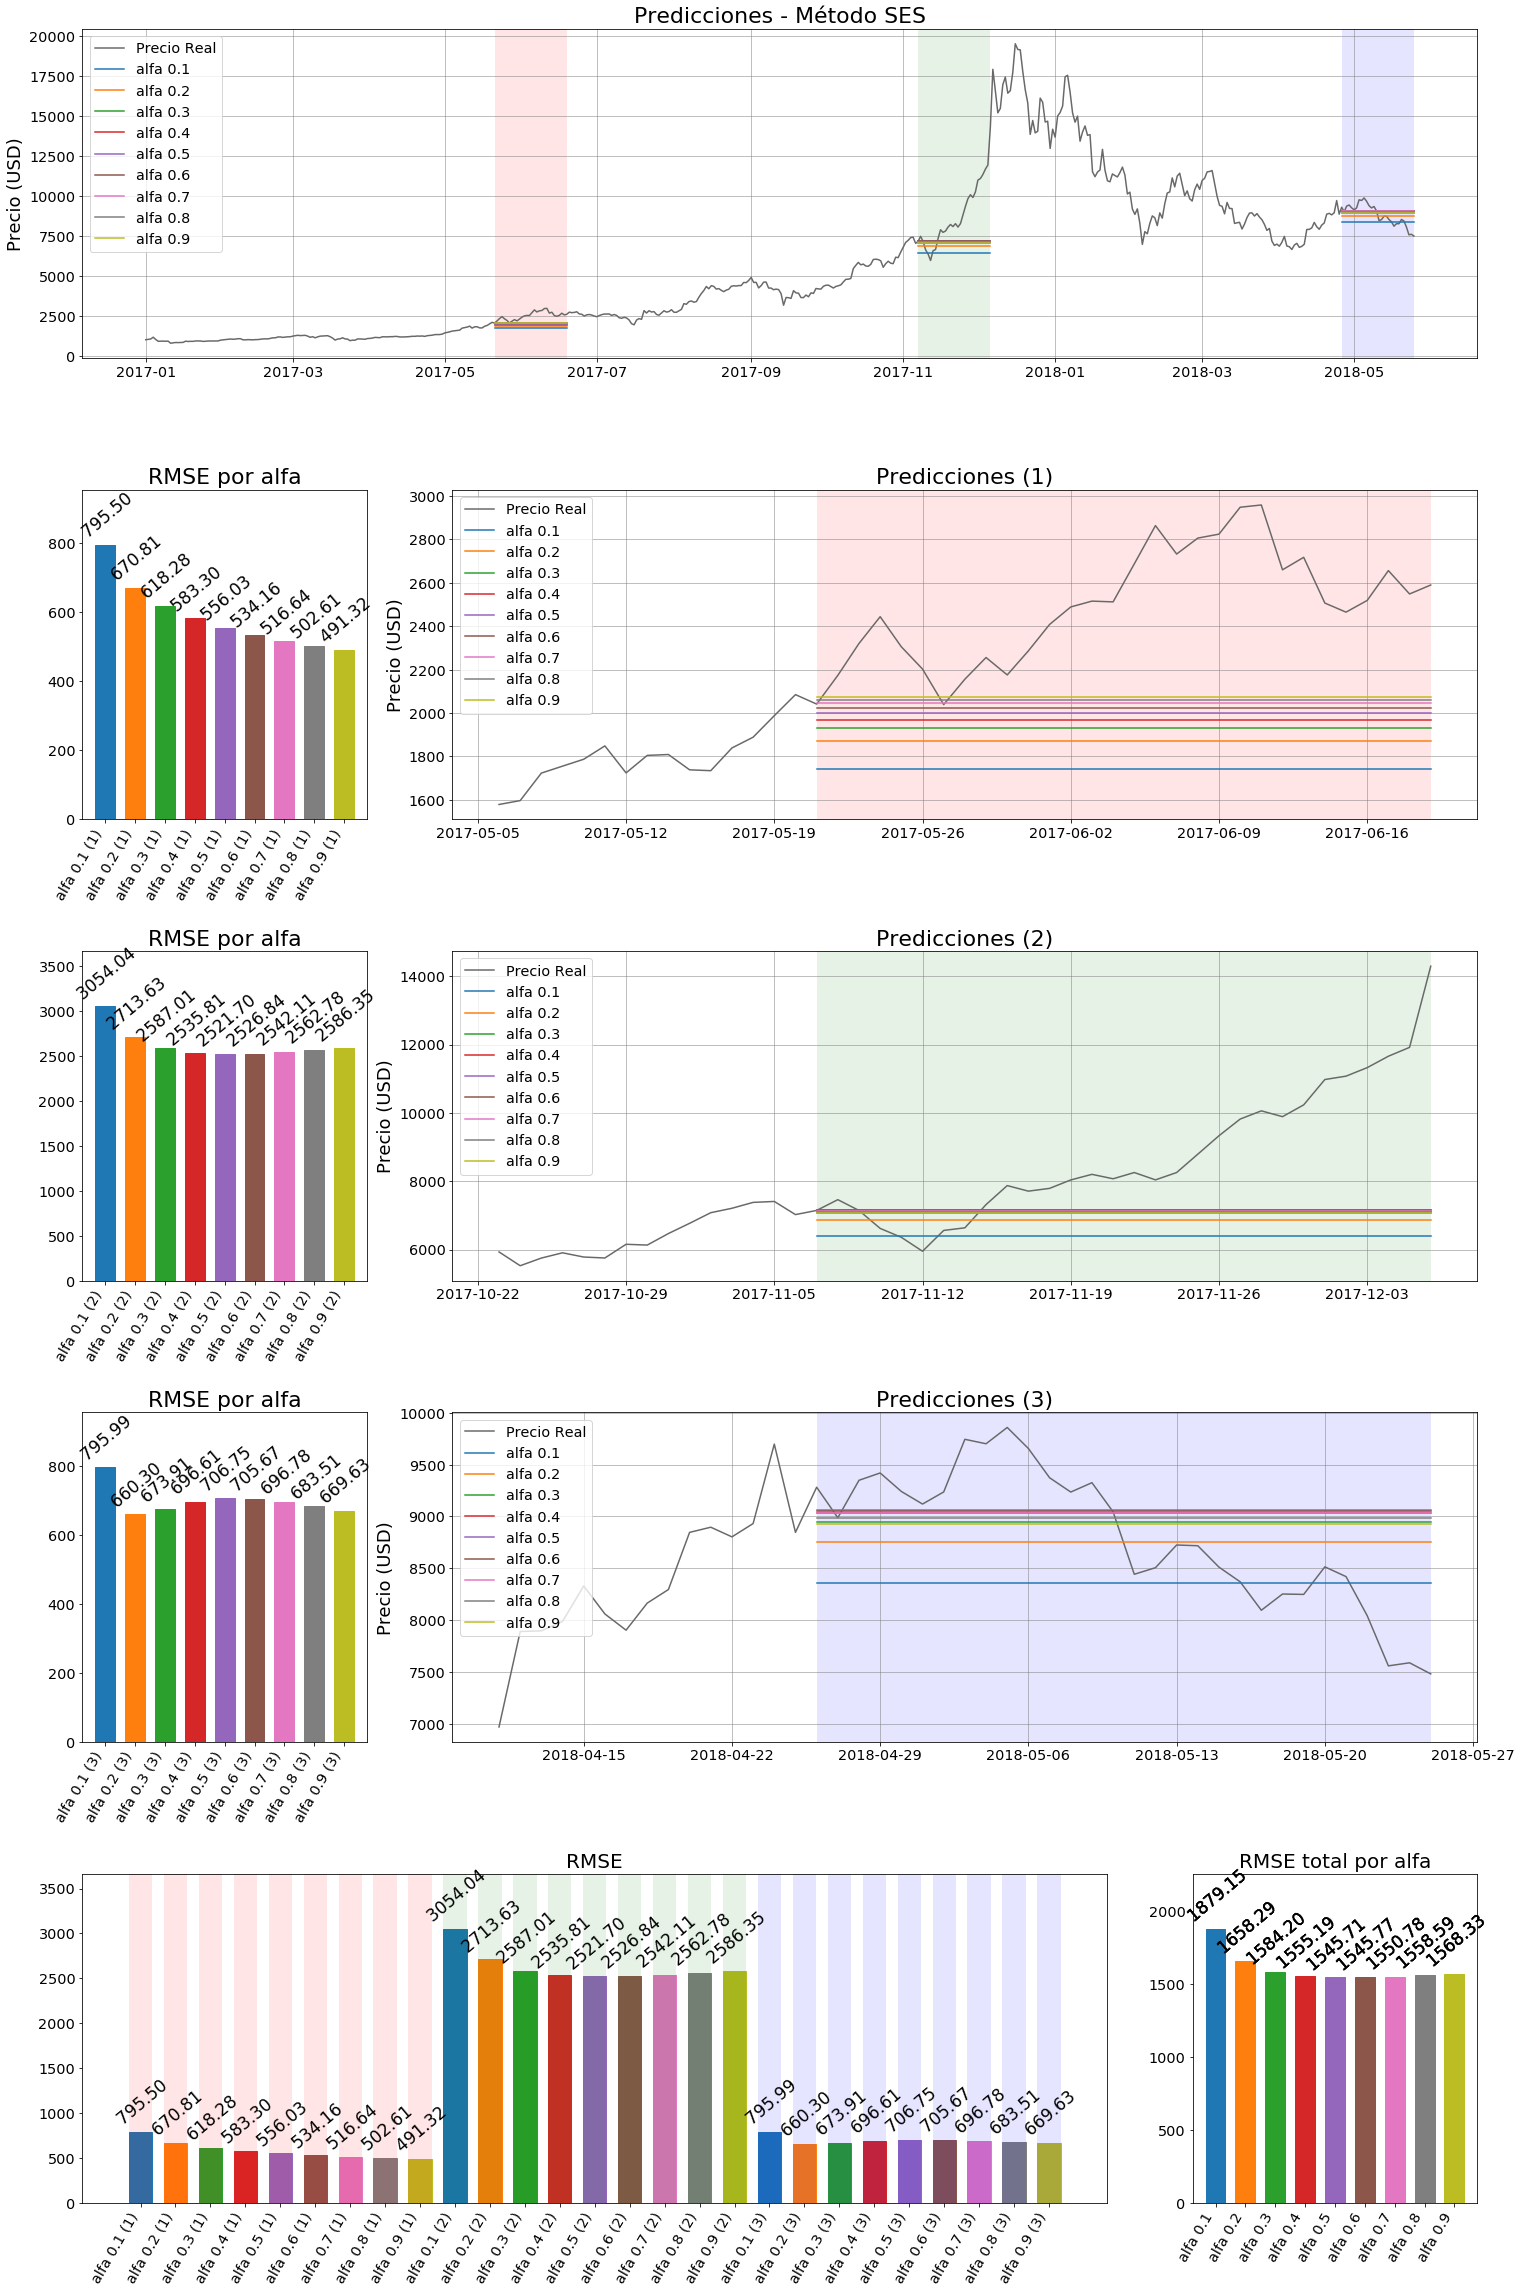

In [16]:
# Simple Exponential Smoothing 0.2
alfas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for alfa in alfas:    
        test['alfa ' + str(alfa)] = np.nan
        training = dataset[0:-test_size]
        ses02 = SimpleExpSmoothing(np.asarray(training)).fit(smoothing_level=alfa,optimized=False)
        test['alfa ' + str(alfa)] = ses02.forecast(test_size)
            
    predicciones = predicciones.append(test)
                
predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/SES_fijo.csv')

graficarBaselines(predicciones,'SES', 'alfa')

Se puede ver que el mejor resultado lo da alfa=0.2. Sin embargo no se mejora el error del método "naive".
En general, estos métodos no funcionan bien para conjuntos de datos con mucha variabilidad.
Para conjuntos de datos que siguen una tendencia, es decir, que tienen un patrón general de movimiento de subida o de bajada (como en este caso), se puede usar el método de "Tendencia Lineal de Holt": es una extensión del método de suavizamiento exponencial simple aplicado al promedio de la serie ("nivel") y a la tendencia. La ecuación de nivel y la de tendencia se suman para general la ecuación de predicción. La suma es apropiada para conjuntos de datos con una tendencia que incrementa o decrementa linealmente, aunque también se puede usar la multiplicación de las ecuaciones de nivel y tendencia si el conjunto de datos muestra una tendencia exponencial. Se compararán los dos métodos.

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

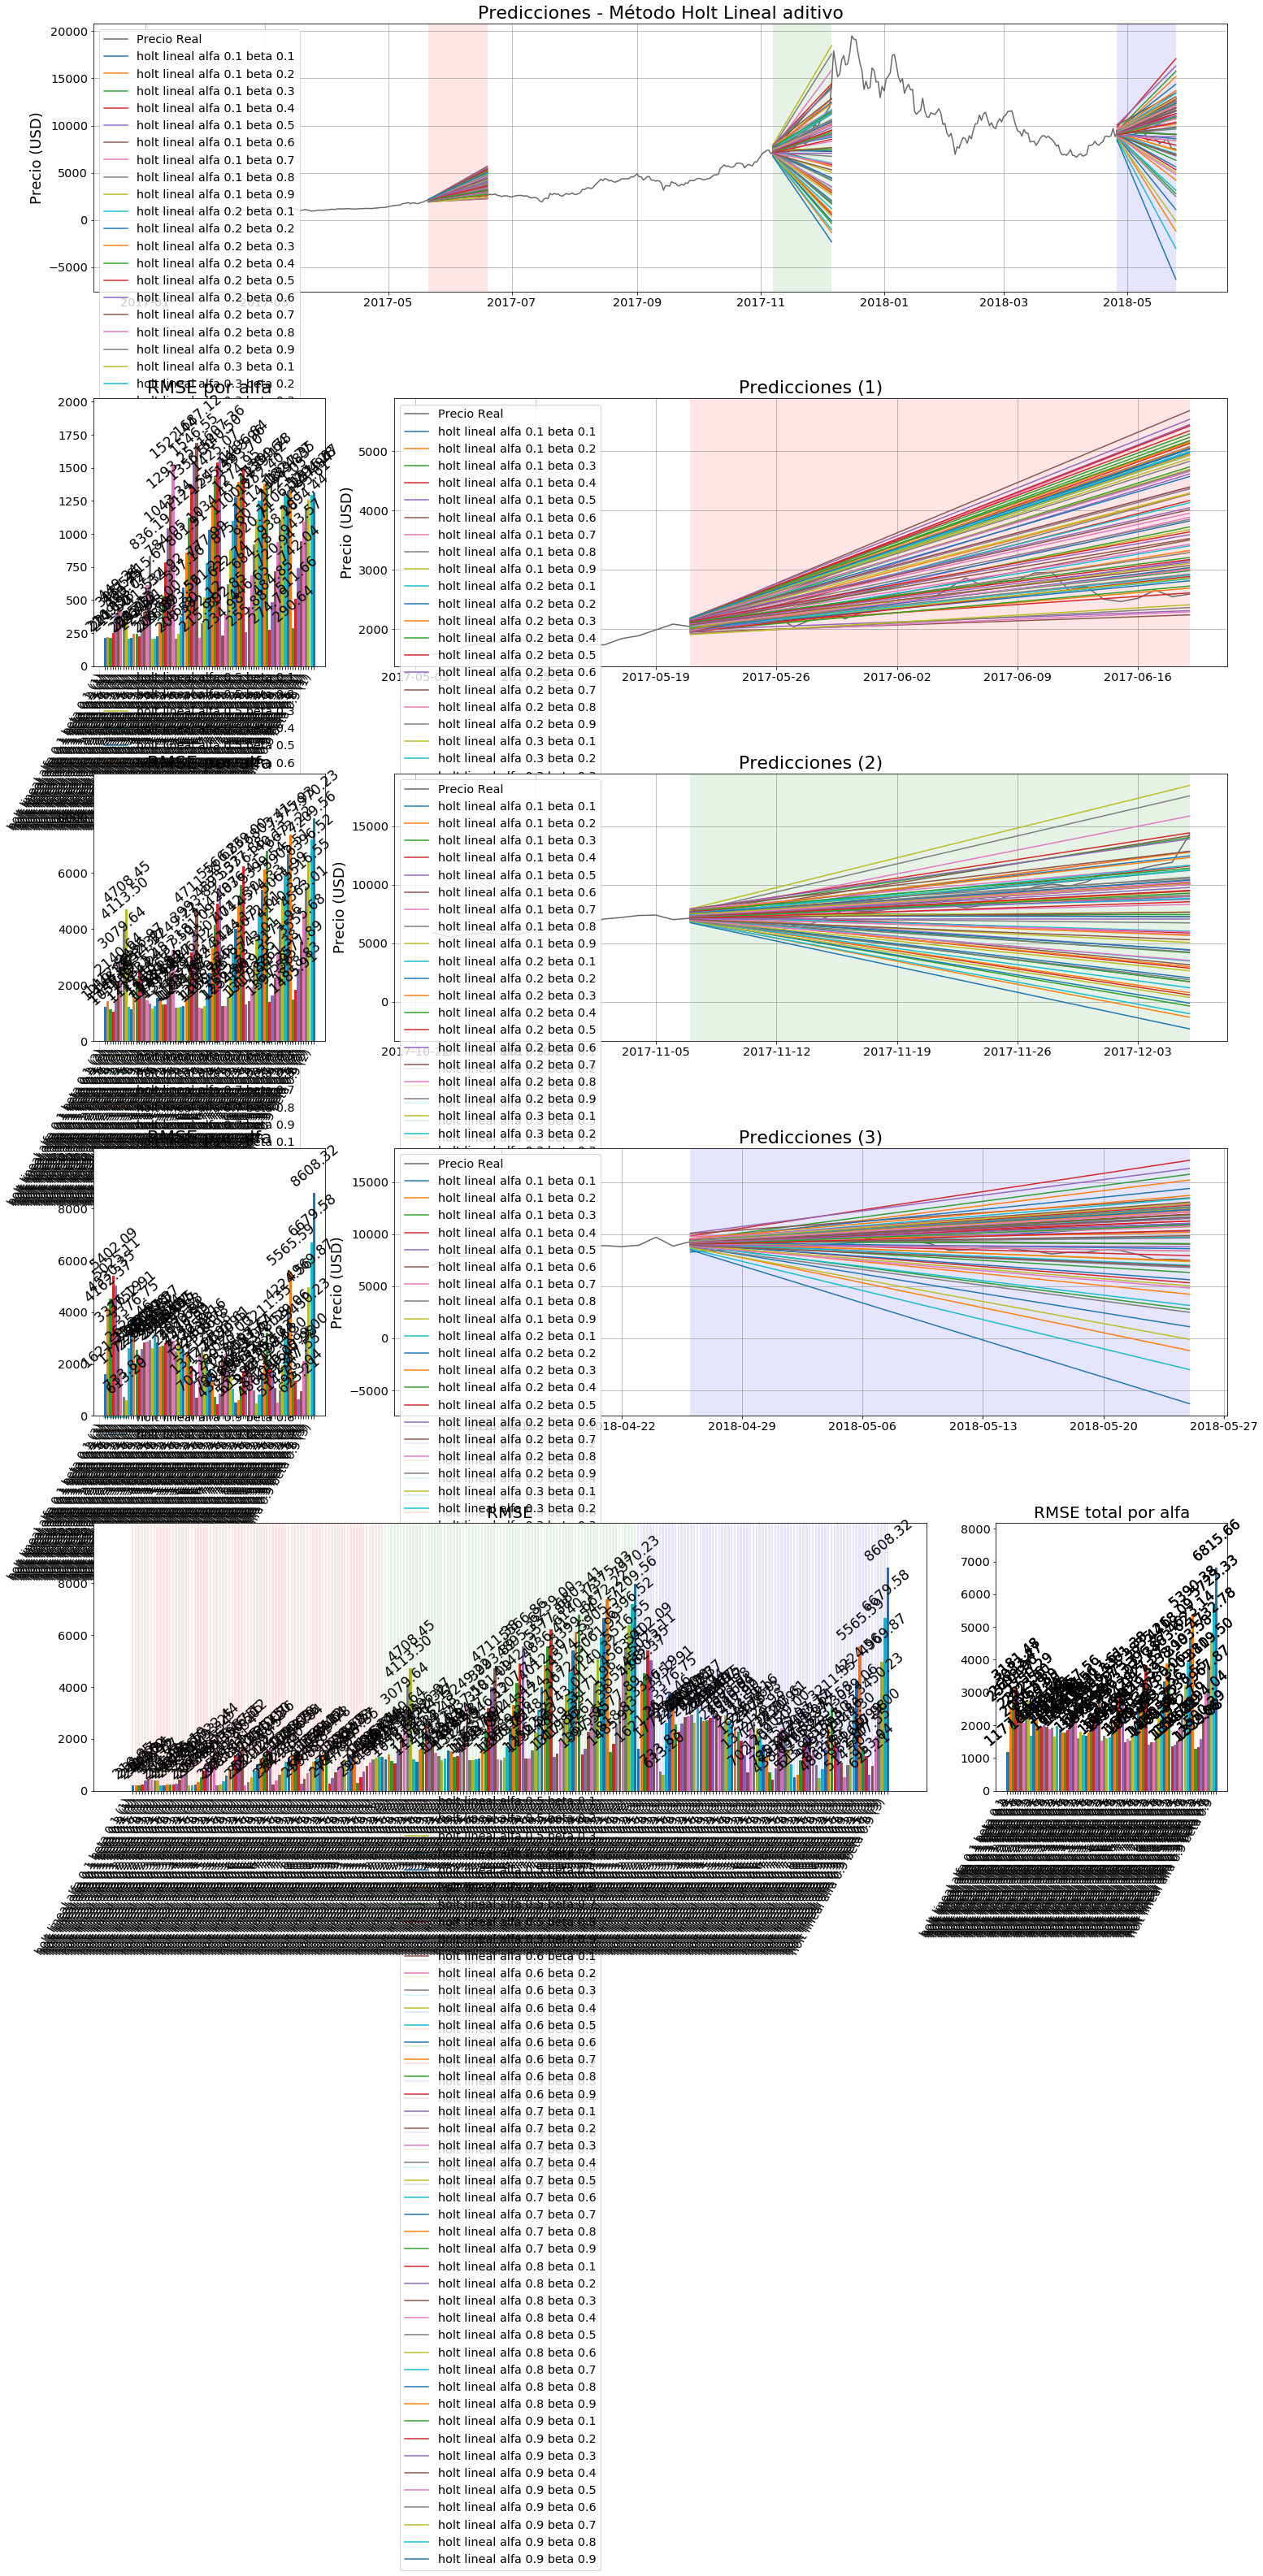

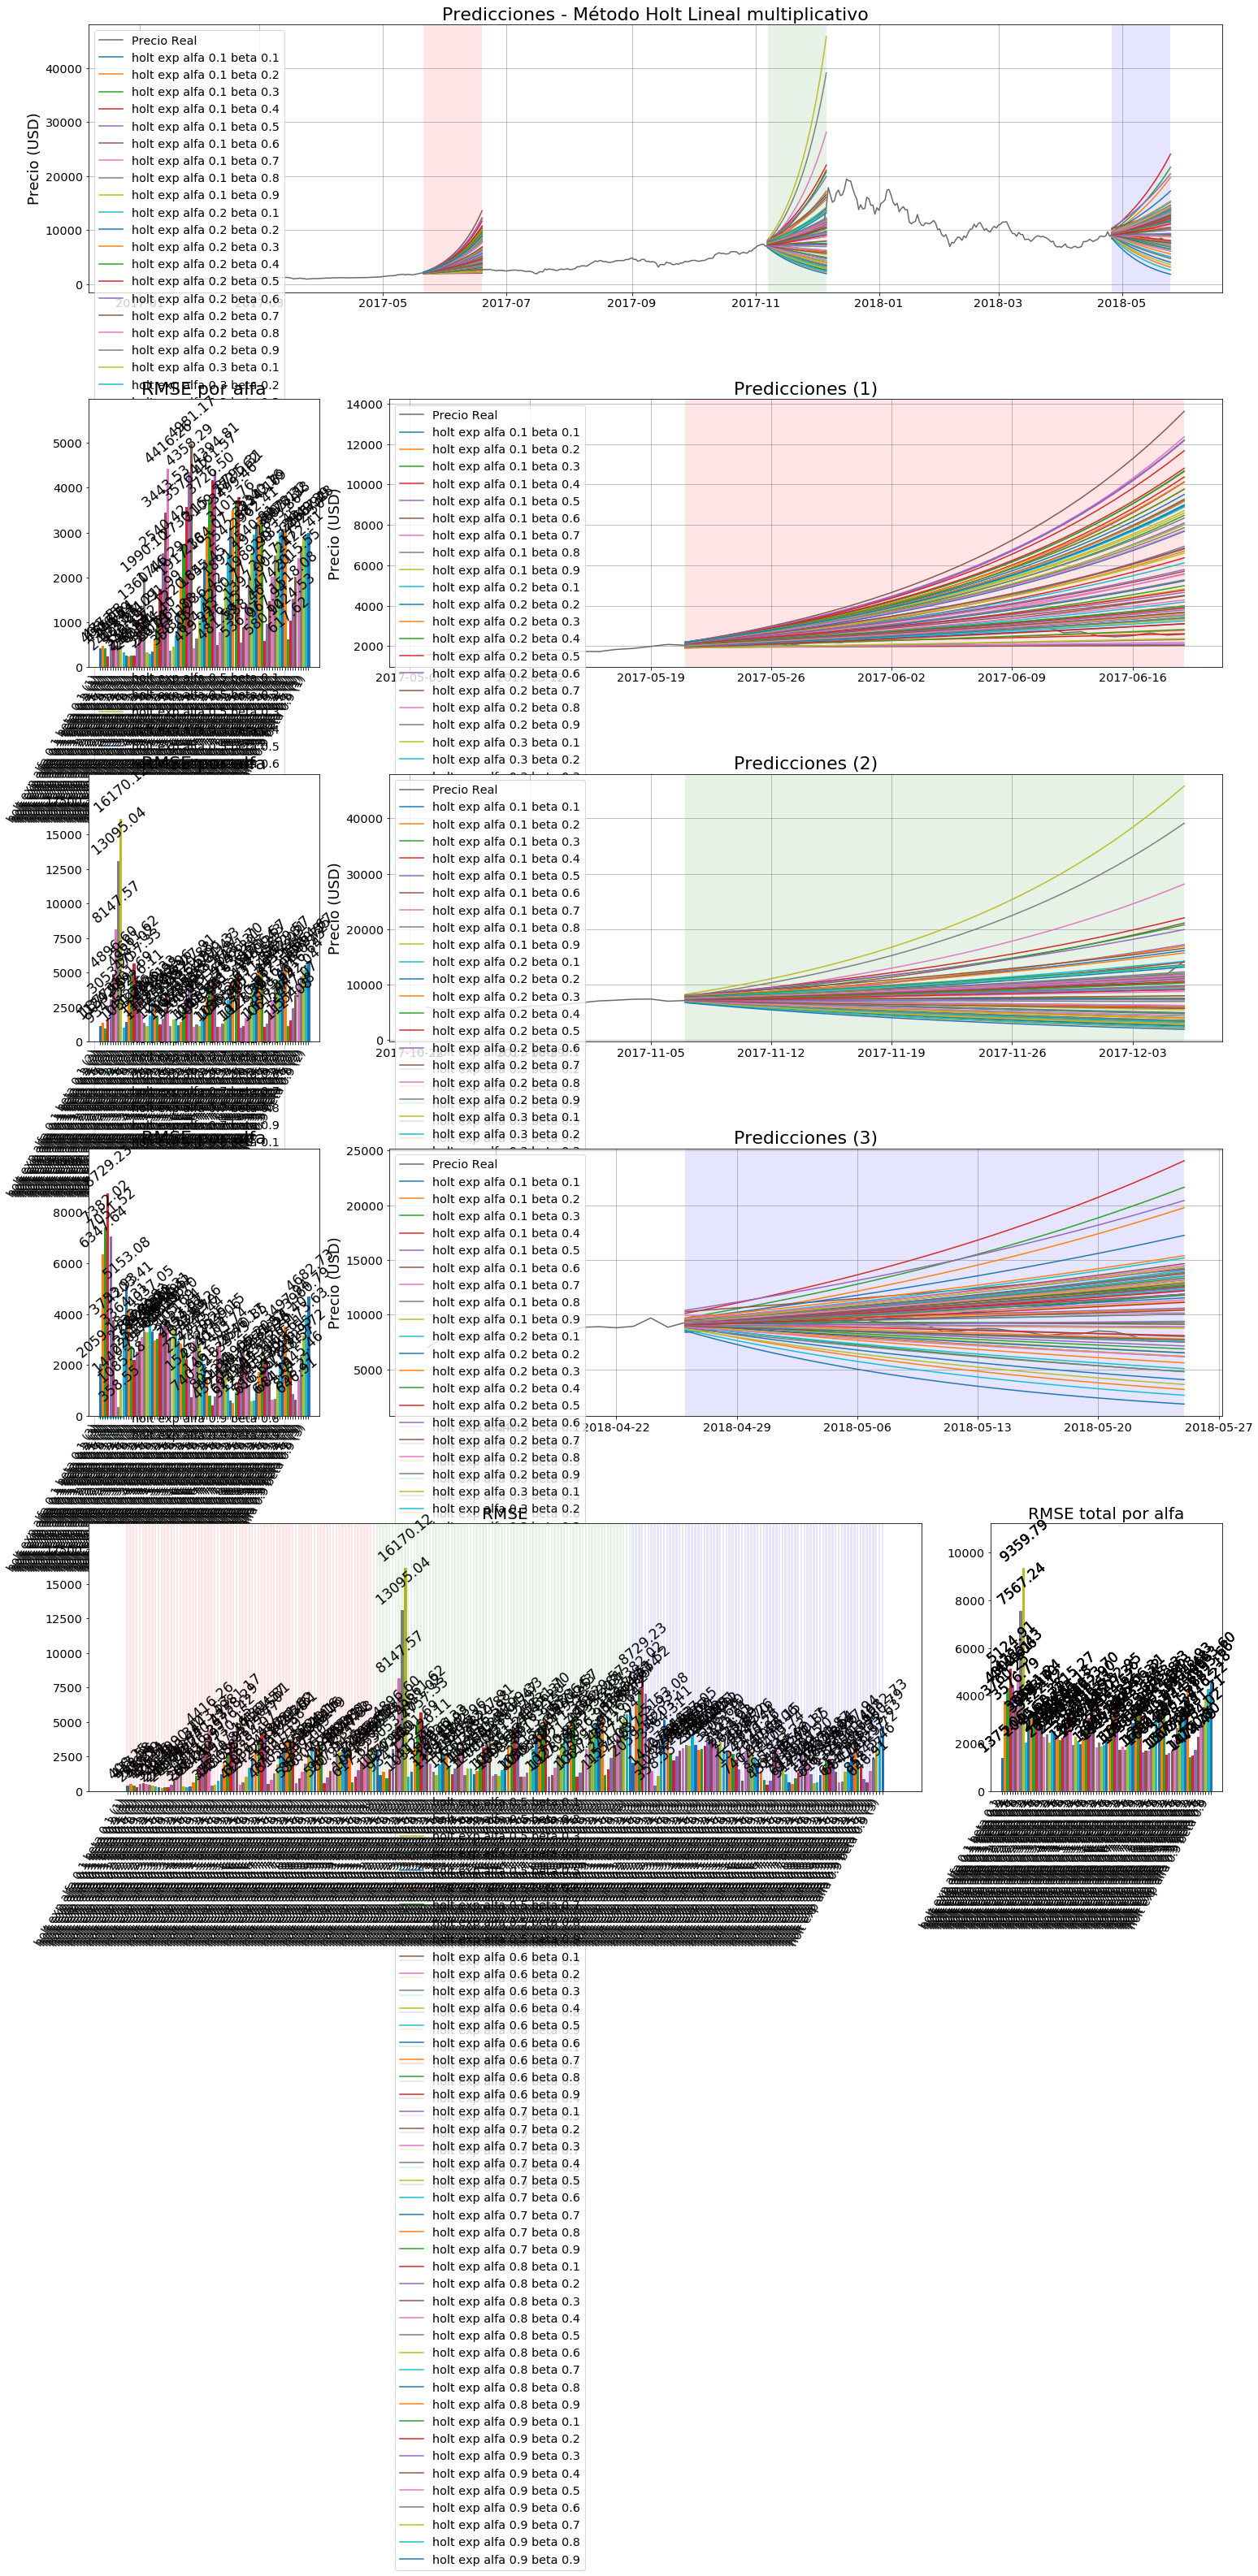

In [19]:
# Holt lineal (conjunto de entrenamiento fijo)
alfas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for alfa in alfas: 
        for beta in betas:   
            test['holt lineal alfa ' + str(alfa) + ' beta ' + str(beta)] = np.nan
            training = dataset[0:-test_size]
            holt_lineal = Holt(np.asarray(training)).fit(smoothing_level = alfa,smoothing_slope = beta)
            test['holt lineal alfa ' + str(alfa) + ' beta ' + str(beta)] = holt_lineal.forecast(test_size)

    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/Holt_lineal_ad_fijo.csv')

graficarBaselines(predicciones,"Holt Lineal aditivo", 'alfa')

# Holt exponencial (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for alfa in alfas:    
        for beta in betas:
            test['holt exp alfa ' + str(alfa) + ' beta ' + str(beta)] = np.nan
            training = dataset[0:-test_size]
            holt_exp = Holt(np.asarray(training), exponential=True).fit(smoothing_level = alfa,smoothing_slope = beta)
            test['holt exp alfa ' + str(alfa) + ' beta ' + str(beta)] = holt_exp.forecast(test_size)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/Holt_lineal_mul_fijo.csv')

graficarBaselines(predicciones,"Holt Lineal multiplicativo", 'alfa') 

Se puede ver que este método no sirve para este conjunto de datos ya que la tendencia cambia con frecuencia, no sigue un patrón.
Se puede intentar el método de Holt-Winters, que toma en cuenta la temporada en el cálculo (por ej. las visitas a un hotel en la playa van a ser influenciadas por la estación del año).
A las ecuaciones de nivel y de tendencia, se suma la ecuación de estacionalidad. Como en el método de Holt, las ecuaciones pueden sumarse o multiplicarse, prefiriendo la multiplicación cuando las variaciones estacionales cambian con el nivel de la serie (en este caso parece ser así).

In [30]:
# Holt-Winters lineal (conjunto de entrenamiento fijo)
ciclos = [7, 30, 45]
alfa = 0.1
beta = 0.1
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método
    for c in ciclos: 
        test['holtwinters ciclo ' + str(c)] = np.nan
        training = dataset[0:-test_size]
        hw_lineal = ExponentialSmoothing(np.asarray(training), seasonal_periods=c, trend='add', seasonal='add').fit(smoothing_level = alfa,smoothing_slope = beta)
        test['holtwinters ciclo ' + str(c)] = hw_lineal.forecast(test_size)
        test['holtwinters ciclo ' + str(c)] = test['holtwinters ciclo ' + str(c)] .interpolate().ffill().fillna(0)
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/HoltWinters_ad_fijo.csv')

#graficarBaselines(predicciones,"Holt-Winters aditivo fijo", 'ciclo')

# Holt-Winters exponencial (conjunto de entrenamiento fijo)
predicciones = pd.DataFrame()
for n_test in range(0,N_tests): 
    end = int((n_test+1)*len(data)/N_tests)
    dataset = data[0:end].copy()
    
    test  = dataset[-test_size:]
    #Método  
    for c in ciclos: 
        test['holtwinters ciclo ' + str(c)] = np.nan
        training = dataset[0:-test_size]
        holt_exp = ExponentialSmoothing(np.asarray(training), seasonal_periods=c, trend='mul', seasonal='mul').fit(smoothing_level = alfa,smoothing_slope = beta)
        test['holtwinters ciclo ' + str(c)] = holt_exp.forecast(test_size)
        test['holtwinters ciclo ' + str(c)] = test['holtwinters ciclo ' + str(c)] .interpolate().ffill().fillna(0)
            
    predicciones = predicciones.append(test)

predicciones = pd.merge(data.copy()[[target]],predicciones.drop(columns=[target]), how="left",left_index=True,right_index=True)
predicciones.to_csv('baselines/HoltWinters_mul_fijo.csv')

#graficarBaselines(predicciones,"Holt-Winters multiplicativo fijo", 'ciclo')

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [26]:
# Construir dataframes con RMSE y epochs por test
def postprocesamiento(prediccion, name, name_parametro, referencia = []):
    rmse_completo_y = []
    rmse_completo_x = []
    for simulacion_i in prediccion.columns[1:]:
                    dataset_name = simulacion_i; i=1
                    prediccionxdataset = pd.DataFrame()
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        subset = prediccion[:end]
                        subset_moneda = subset[subset.columns[0]]
                        subset_prediccion = subset[[simulacion_i]][-test_size:]
                        prediccionxdataset = prediccionxdataset.append(
                            pd.concat([subset_moneda[-test_size:], subset_prediccion], axis=1))                 
                                              
                        #RMSE
                        rmse = sqrt(mean_squared_error(subset_moneda[-test_size:], subset_prediccion))
                        rmse_completo_y.append(rmse)
                        rmse_completo_x.append(simulacion_i + ' RMSE (' + str(i) + ')')

                        i+=1
                   
                    rmse_general = sqrt(mean_squared_error(prediccionxdataset[prediccionxdataset.columns[0]], 
                                                           prediccionxdataset[prediccionxdataset.columns[1]]))
                    rmse_completo_y.append(rmse_general)
                    rmse_completo_x.append(simulacion_i + 'RMSE (General)')
                    
    # Construir un csv con todos los RMSE
    arreglo_rmse = []; i=0
    for simulacion_i in prediccion.columns[1:]:
        arreglo_rmse.append([simulacion_i] + rmse_completo_y[i:i+4]); i+=4
    dataframe_rmse = pd.DataFrame(arreglo_rmse, columns=['Simulacion','RMSE (1)','RMSE (2)','RMSE (3)','RMSE (General)'])
    dataframe_rmse.set_index('Simulacion',inplace=True)
    dataframe_rmse.to_csv('baselines' + '/' + name + ' RMSE.csv')
    print('RMSEs guardados: ' + 'baselines' + '/' + name + ' RMSE.csv')
            
    # Graficar RMSE en barras
    width = 1/1.5
    plt.figure(figsize=(25,8))
    barplot = plt.bar(rmse_completo_x, rmse_completo_y, width)
    col = 0;
    for rect in barplot: # Valores en las barras
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom',rotation=90)
        rect.set_color(colores_test[col])
        col = (col+1)%4
    plt.xticks(rotation=60, ha="right")
    plt.ylim(ymax=max(rmse_completo_y)*1.2)
    plt.ylabel('Error', fontsize=18)
    plt.title("RMSE", fontsize=22)
    plt.savefig('baselines' + '/' + name + ' RMSE barras.png', bbox_inches='tight')  
    
    #Graficar RMSE por variación del parámetro
    plt.figure(figsize=(20,8)); col = 0
    for i in range(0,len(dataframe_rmse.columns)):
        plt.plot(dataframe_rmse.index, dataframe_rmse[dataframe_rmse.columns[i]], label=dataframe_rmse.columns[i], color=colores_test[col]);  col = (col+1)%4
    for r in referencia:
        plt.axhline(r,linestyle='--', color=colores_test[col], alpha=0.6); col=(col+1)%4
    plt.legend(loc='upper left')
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel('Error', fontsize=18)
    plt.title("RMSE vs. " + name_parametro,fontsize=20)
    plt.savefig('baselines' + '/' + name + 'RMSE lineal.png', bbox_inches='tight') 
    plt.show()
    
    return dataframe_rmse

# Construir dataframes con RMSE y epochs por test
def postprocesamientoHOLT(prediccion, name, name_parametro, referencia = []):
    rmse_completo_y = []
    rmse_completo_x = []
    for simulacion_i in prediccion.columns[1:]:
                    dataset_name = simulacion_i; i=1
                    prediccionxdataset = pd.DataFrame()
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        subset = prediccion[:end]
                        subset_moneda = subset[subset.columns[0]]
                        subset_prediccion = subset[[simulacion_i]][-test_size:]
                        prediccionxdataset = prediccionxdataset.append(
                            pd.concat([subset_moneda[-test_size:], subset_prediccion], axis=1))                 
                                              
                        #RMSE
                        rmse = sqrt(mean_squared_error(subset_moneda[-test_size:], subset_prediccion))
                        rmse_completo_y.append(rmse)
                        rmse_completo_x.append(simulacion_i + ' RMSE (' + str(i) + ')')

                        i+=1
                   
                    rmse_general = sqrt(mean_squared_error(prediccionxdataset[prediccionxdataset.columns[0]], 
                                                           prediccionxdataset[prediccionxdataset.columns[1]]))
                    rmse_completo_y.append(rmse_general)
                    rmse_completo_x.append(simulacion_i + 'RMSE (General)')
               
    # Construir un csv con todos los RMSE
    arreglo_rmse = []; i=0
    for simulacion_i in prediccion.columns[1:]:
        arreglo_rmse.append([simulacion_i] + rmse_completo_y[i:i+4]); i+=4
    dataframe_rmse = pd.DataFrame(arreglo_rmse, columns=['Simulacion','RMSE (1)','RMSE (2)','RMSE (3)','RMSE (General)'])
    dataframe_rmse.set_index('Simulacion',inplace=True)
    dataframe_rmse.to_csv('baselines' + '/' + name + ' RMSE.csv')
    print('RMSEs guardados: ' + 'baselines' + '/' + name + ' RMSE.csv')
    
    #Graficar RMSE por variación del parámetro
    fig, ax = plt.subplots(1, 1, figsize=(20,8)); col = 0
    for i in range(0,len(dataframe_rmse.columns)):
        plt.plot(dataframe_rmse.index, dataframe_rmse[dataframe_rmse.columns[i]], label=dataframe_rmse.columns[i], color=colores_test[col]);  col = (col+1)%4
    for r in referencia:
        plt.axhline(r,linestyle='--', color=colores_test[col], alpha=0.6); col=(col+1)%4
    plt.legend(loc='upper left')
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    ax.set_xticks(ax.get_xticks()[::9])
    plt.xticks(rotation=20, ha="right")
    plt.ylabel('Error', fontsize=18)
    plt.title("RMSE vs. " + name_parametro,fontsize=20)
    plt.savefig('baselines' + '/' + name + 'RMSE lineal.png', bbox_inches='tight') 
    plt.show()
    
    return dataframe_rmse

# Graficar la simulacion i para la prediccion 
def graficarSimulacion(prediccion,simulacion_i,dataframe_rmse, name, name_parametro):
                    dataset_name = simulacion_i
                    i = 1
                    
                    #Visualización de resultados
                    fig = plt.figure(figsize=(25,10*4))
                    gs = gridspec.GridSpec(4, 9, wspace=0.3, hspace=0.4)

                    #Todas los subsets para un dataset
                    axPrediccionCompleta = plt.subplot(gs[0, 0:])
                    axPrediccionCompleta.plot(prediccion.index, prediccion[prediccion.columns[0]], color='dimgray', label="Precio Real")  
                    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
                    plt.xticks(rotation=30, ha="right")
                    axPrediccionCompleta.set_title("Predicciones " + name,fontsize=22)
                    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
                    rmse_general = dataframe_rmse.loc[simulacion_i, 'RMSE (General)'] # Obtener el RMSE para la prediccion
                    axPrediccionCompleta.text(0.05, 0.1, 'RMSE ' + str('% 6.2f' % rmse_general), 
                                            horizontalalignment='left',verticalalignment='center', 
                                            transform=axPrediccionCompleta.transAxes, fontsize=17, bbox=dict(facecolor='red', alpha=0.5))
                  
                    prediccionxdataset = pd.DataFrame()
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        subset = prediccion[:end]
                        subset_moneda = subset[subset.columns[0]]
                        subset_prediccion = subset[[simulacion_i]][-test_size:]
                        prediccionxdataset = prediccionxdataset.append(
                            pd.concat([subset_moneda[-test_size:], subset_prediccion], axis=1))
                        
                        #Graficar la serie completa
                        axPrediccionCompleta.plot(subset_prediccion.index, subset_prediccion, color=colores_test[n_test], label='Prediccion (' + str(n_test+1) + ')')
                        axPrediccionCompleta.axvspan(subset_prediccion.index[0], subset_prediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)  
                        axPrediccionCompleta.legend(loc='upper left')                                           
                                              
                        #Cada prediccion   
                        axPrediccion = plt.subplot(gs[i, 1:8])
                        axPrediccion.plot(subset_moneda.index[-45:], subset_moneda[-45:], color='dimgray', label="Precio Real")
                        axPrediccion.plot(subset_prediccion.index, subset_prediccion, color=colores_test[n_test],  label='Prediccion ' + simulacion_i + ' (' + str(i) + ')')
                        axPrediccion.axvspan(subset_prediccion.index[0], subset_prediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)
                        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
                        plt.xticks(rotation=30, ha="right")
                        axPrediccion.legend(loc='upper left')
                        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
                        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5)                         
                        rmse_i = dataframe_rmse.loc[simulacion_i, 'RMSE ('+ str(i) +')'] # Obtener el RMSE para la prediccion
                        axPrediccion.text(0.05, 0.1, 'RMSE ' + str('% 6.2f' % rmse_i), 
                                            horizontalalignment='left',verticalalignment='center', 
                                            transform=axPrediccion.transAxes, fontsize=17, bbox=dict(facecolor='red', alpha=0.5))
                        i+=1
                    
                    plt.savefig('baselines' + '/' + name + '.png', bbox_inches='tight') 

RMSEs guardados: baselines/SES RMSE.csv


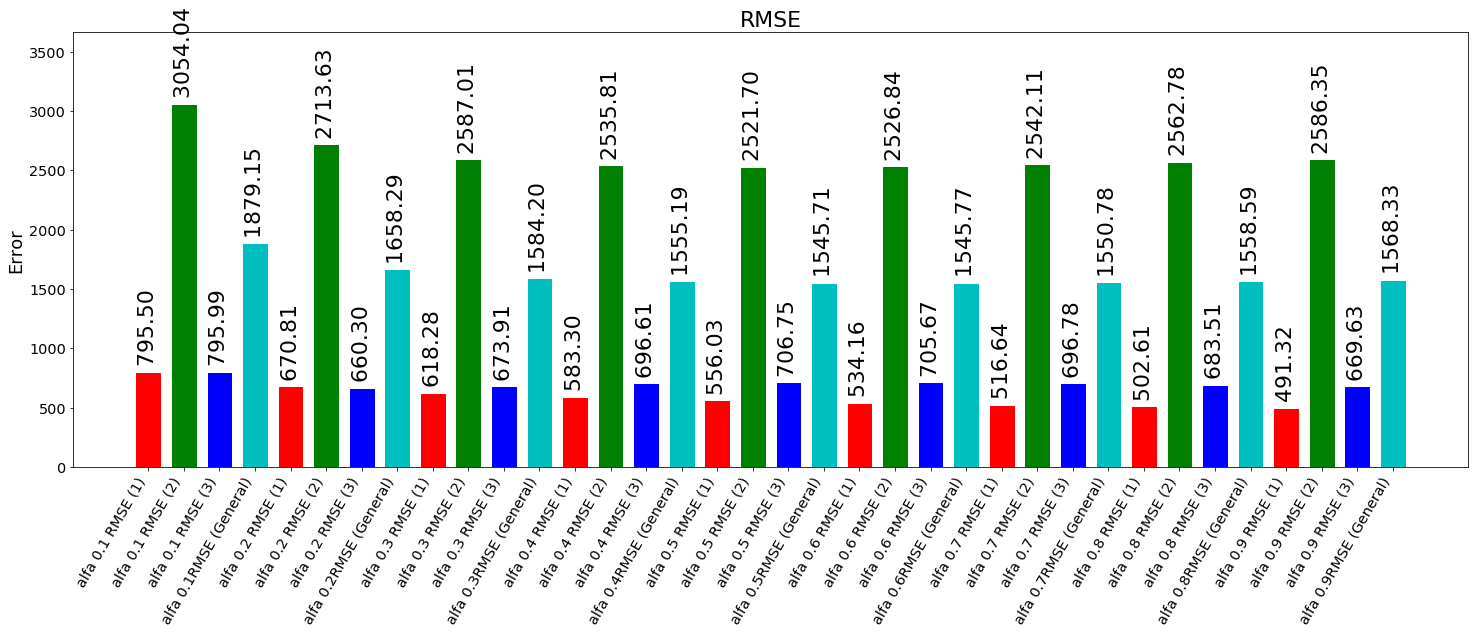

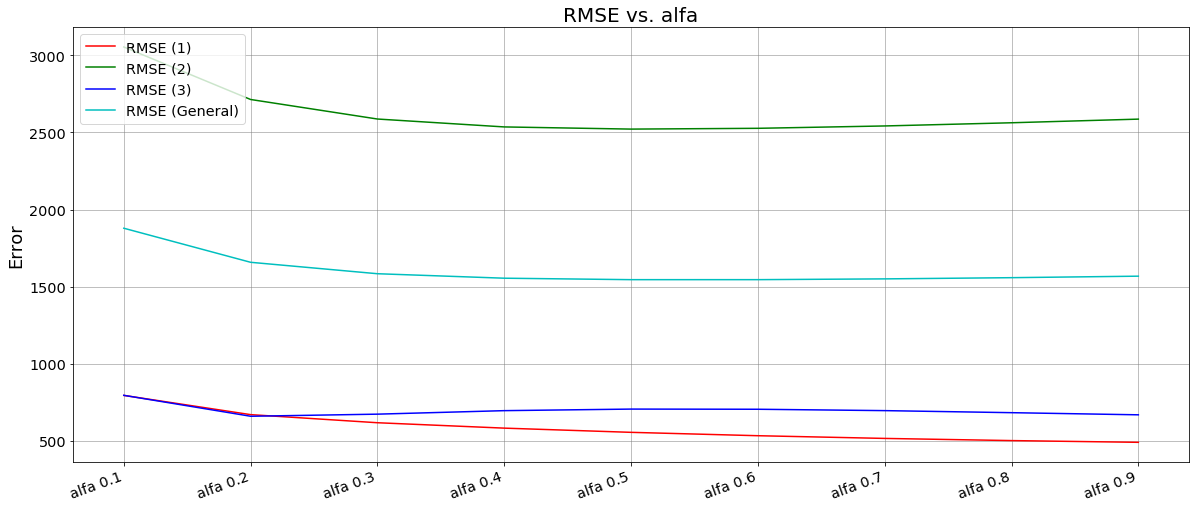

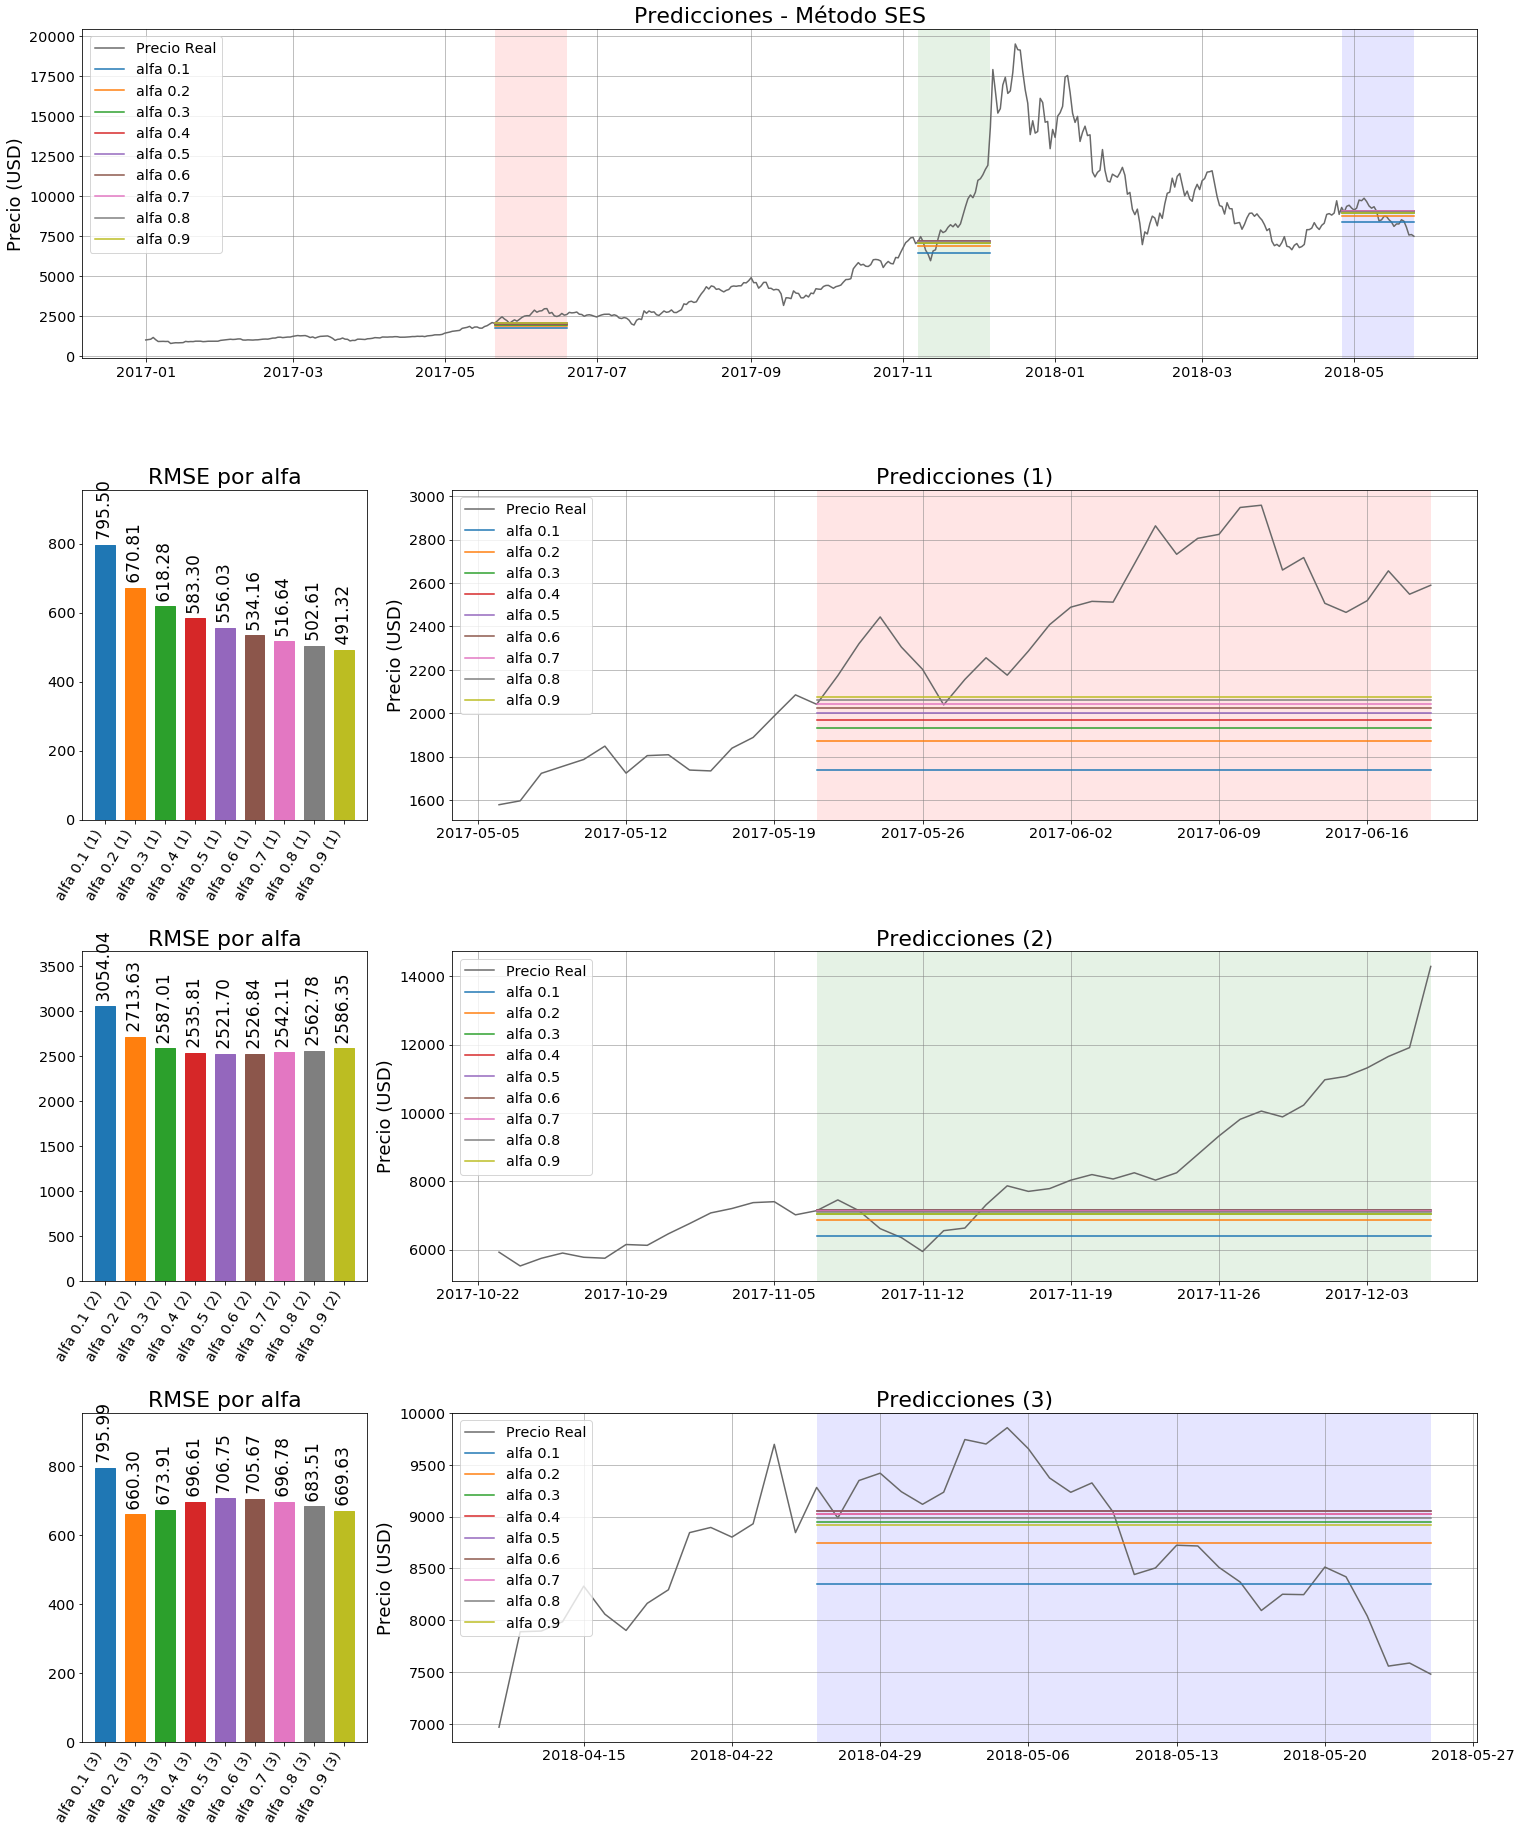

In [31]:
# SES
prediccion_SES = pd.read_csv('baselines/SES_fijo.csv')
prediccion_SES['Date'] = pd.to_datetime(prediccion_SES['Date'])
prediccion_SES.set_index('Date', inplace=True)

dataframe_rmse_SES = postprocesamiento(prediccion_SES, name='SES', name_parametro='alfa')
graficarBaselines(prediccion_SES,'SES', 'alfa')


RMSEs guardados: baselines/Holt lineal aditivo RMSE.csv


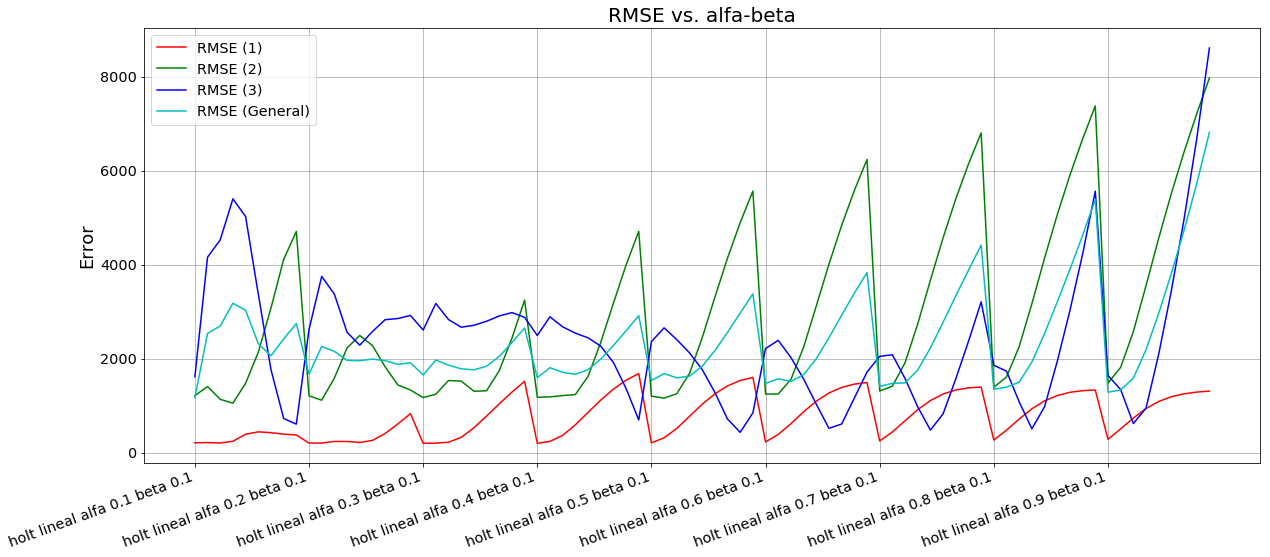

RMSE (1)          holt lineal alfa 0.4 beta 0.1
RMSE (2)          holt lineal alfa 0.1 beta 0.4
RMSE (3)          holt lineal alfa 0.5 beta 0.8
RMSE (General)    holt lineal alfa 0.1 beta 0.1
dtype: object
RMSE (1)           205.531510
RMSE (2)          1058.617288
RMSE (3)           438.852474
RMSE (General)    1177.896460
dtype: float64
RMSEs guardados: baselines/Holt lineal multiplicativo RMSE.csv


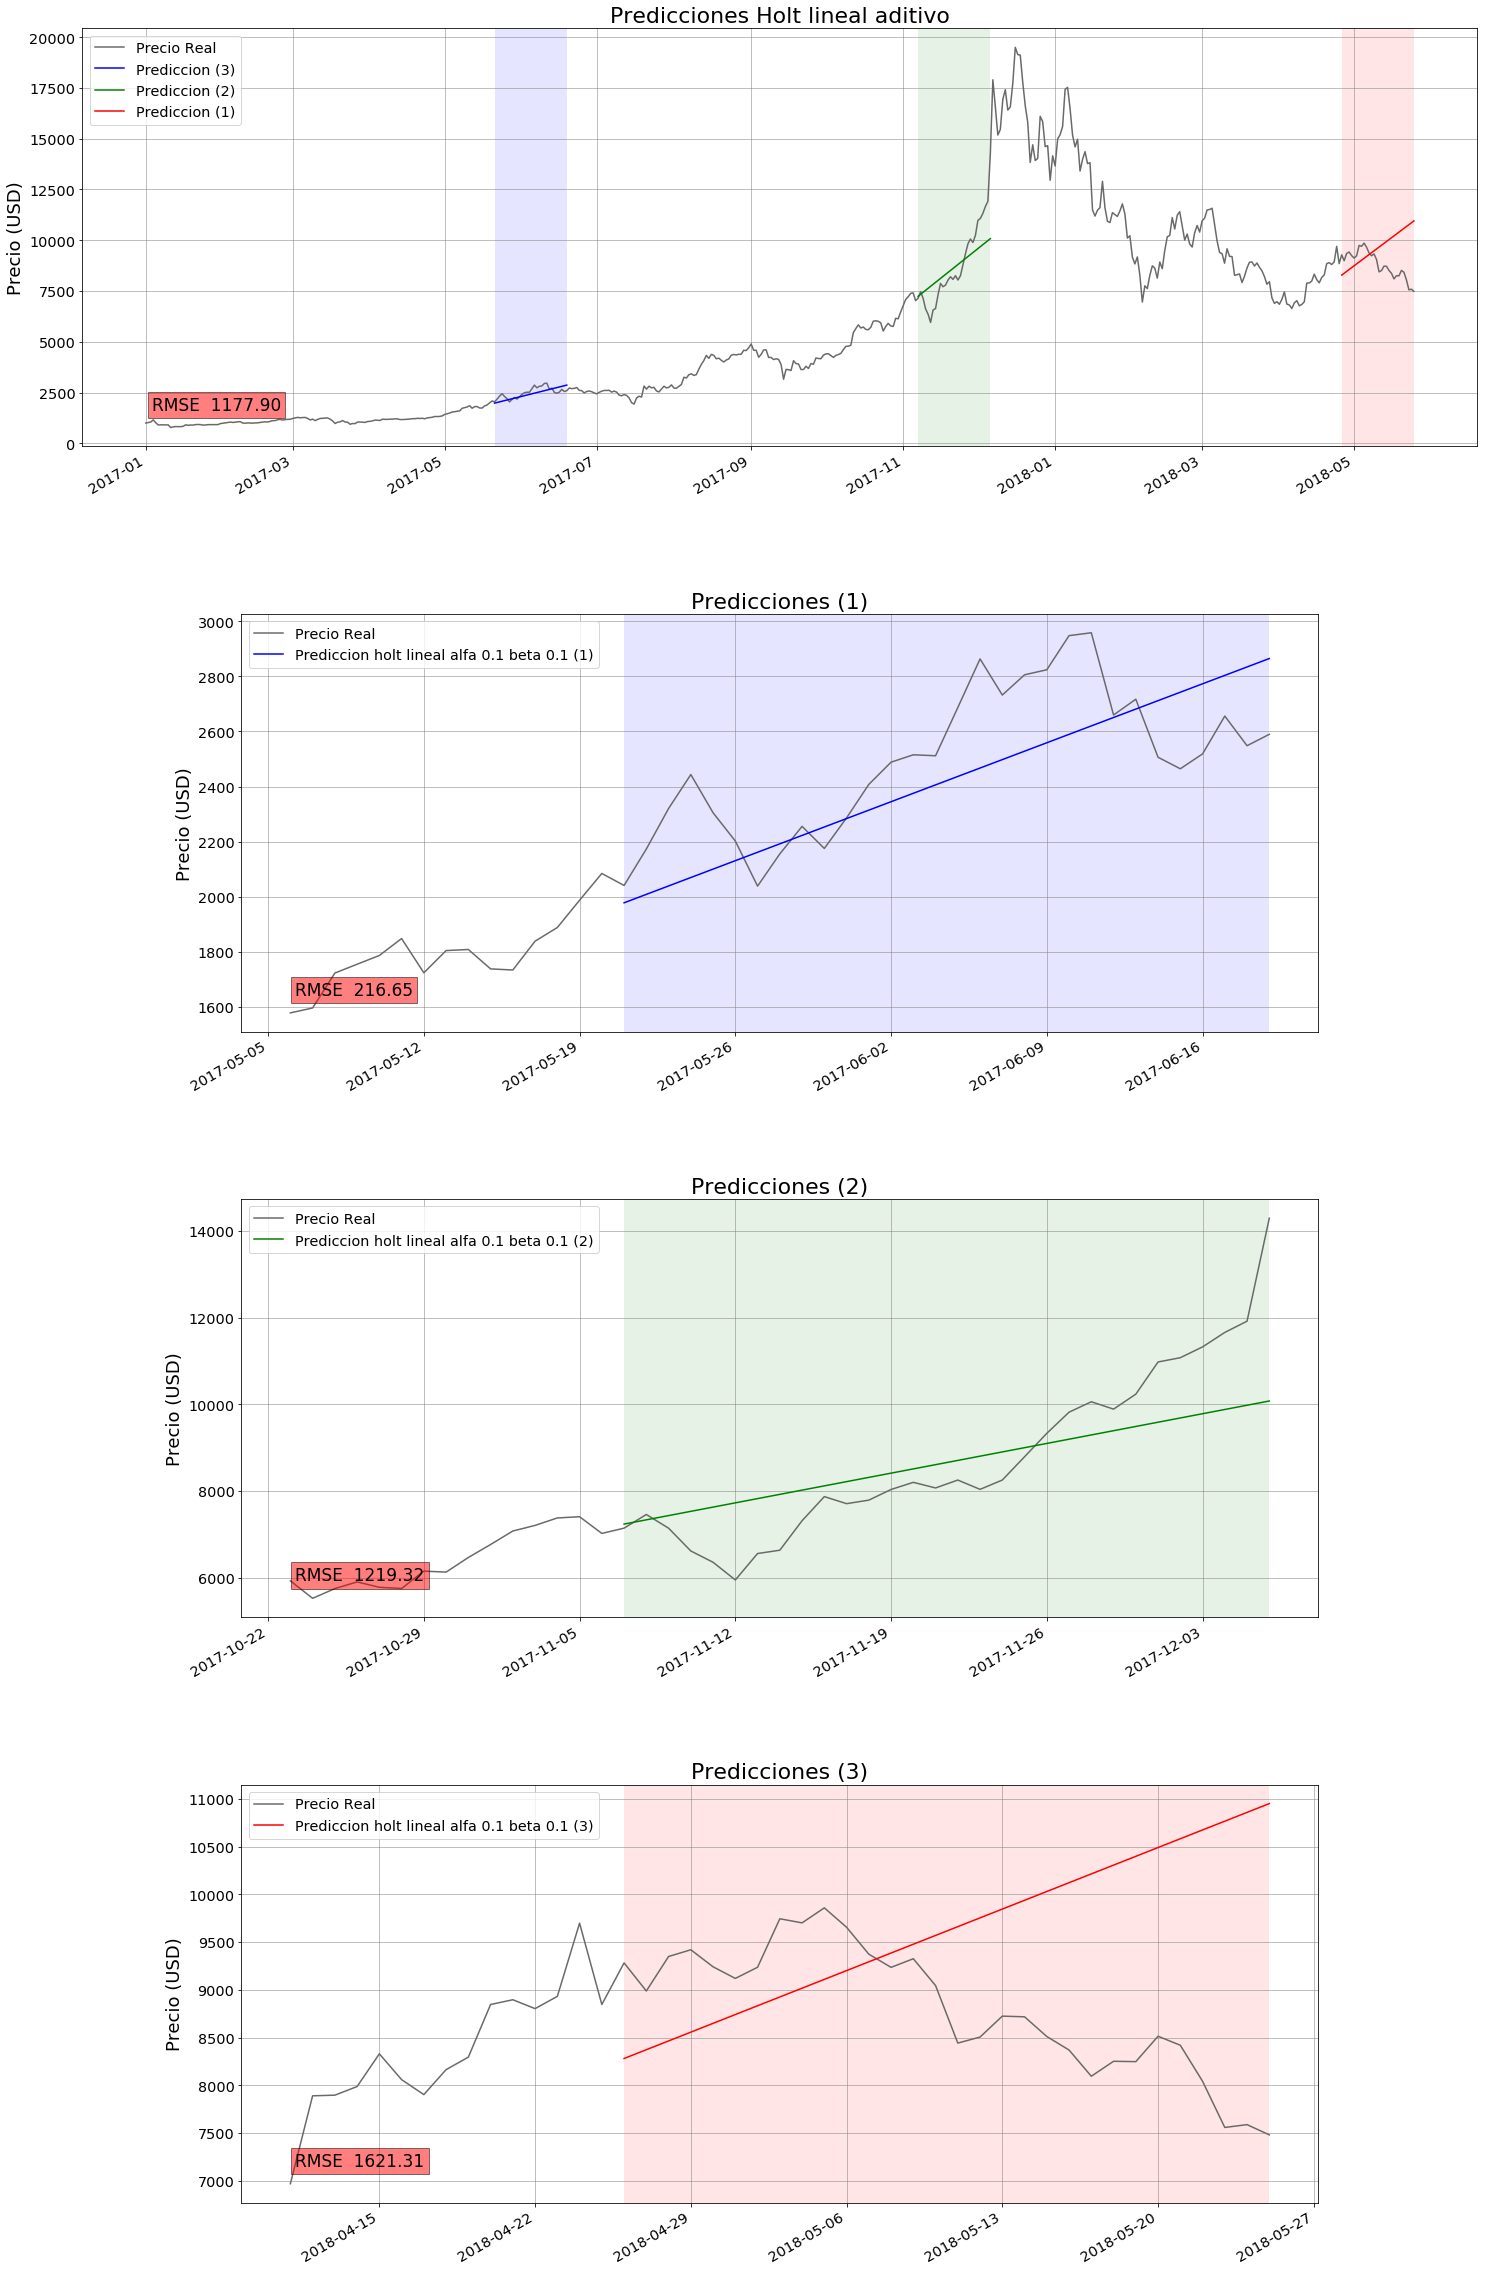

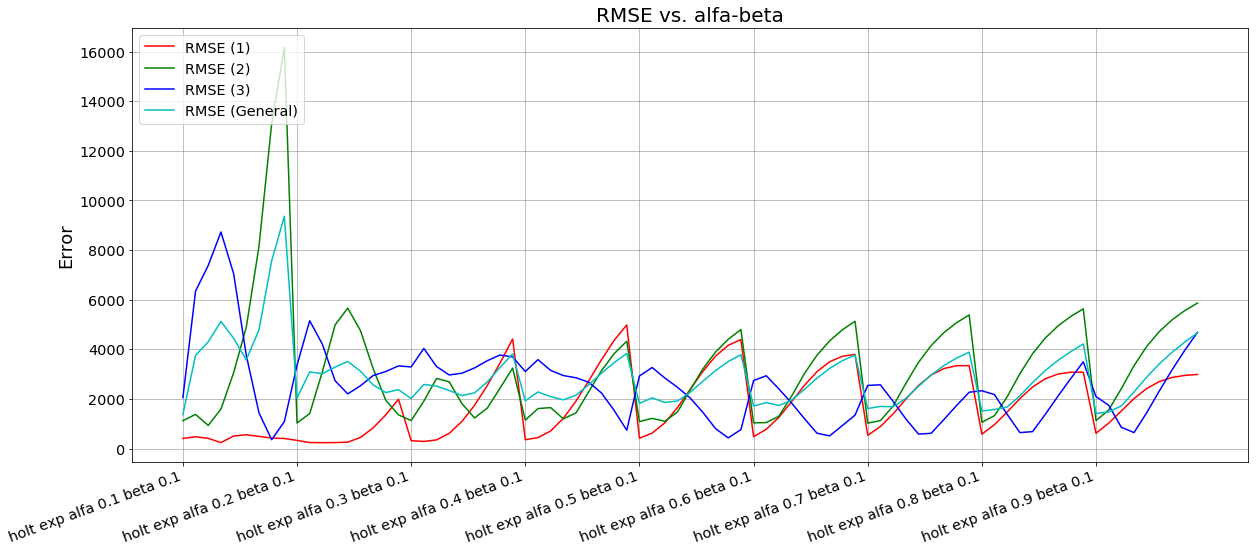

RMSE (1)           238.942880
RMSE (2)           934.116859
RMSE (3)           358.546067
RMSE (General)    1375.058600
dtype: float64


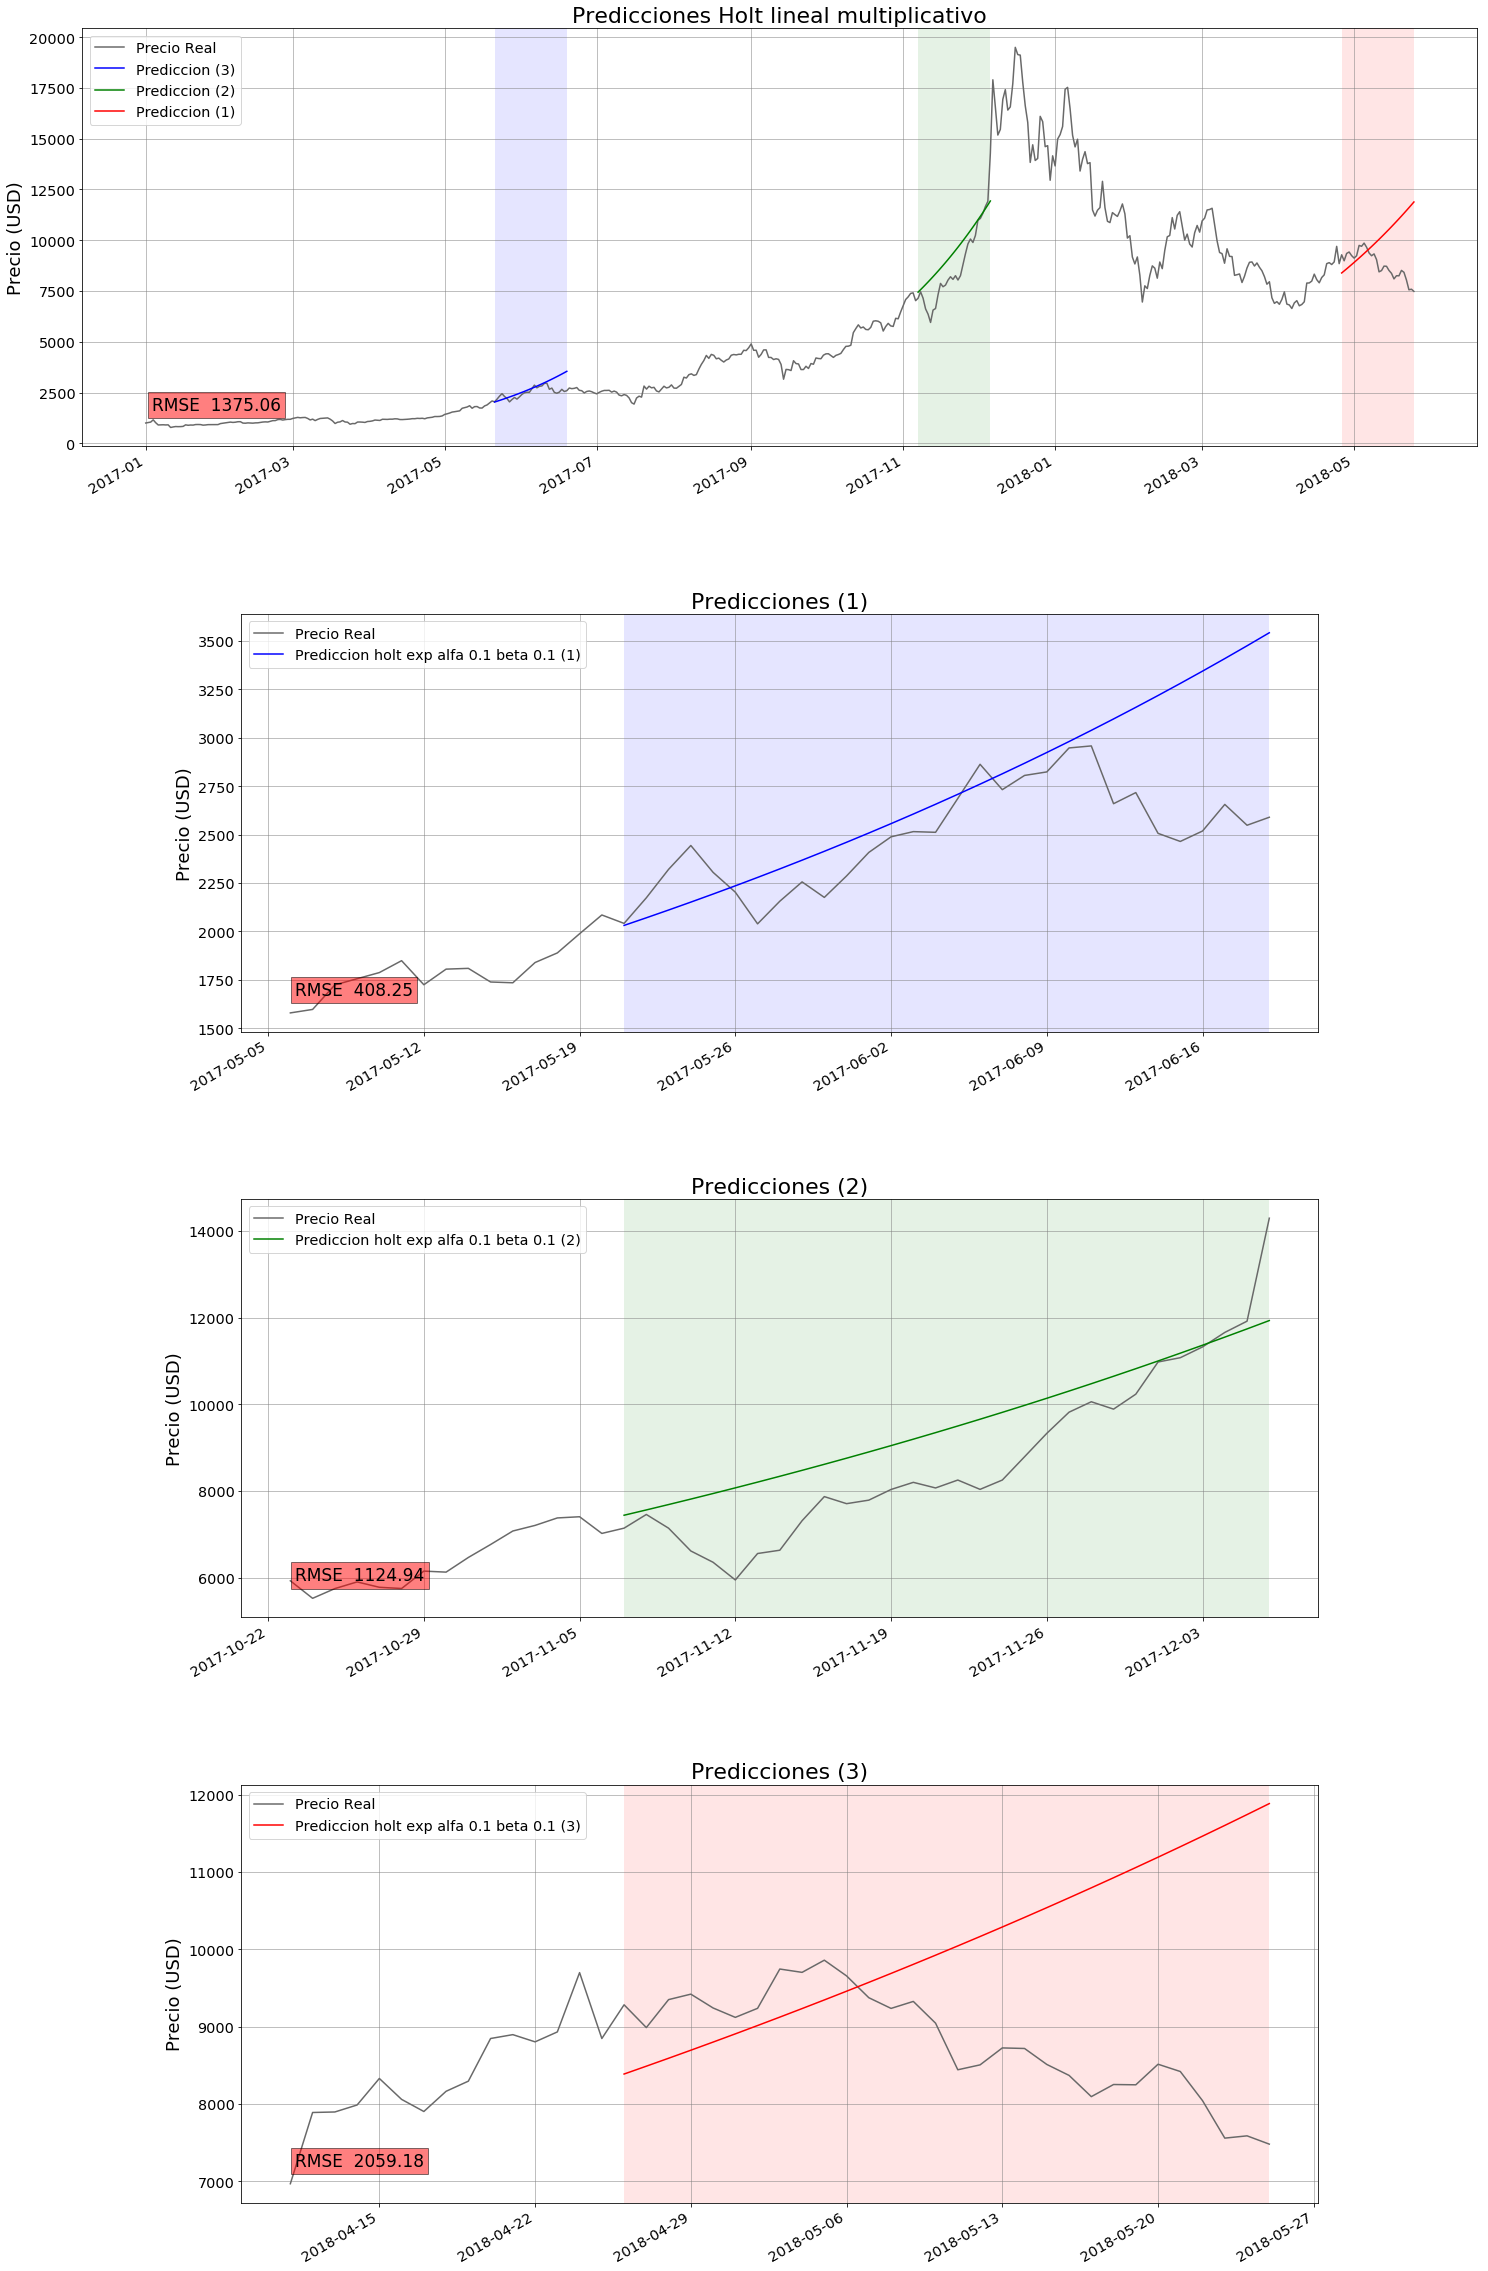

In [32]:
# HOLT LINEAL
prediccion_HLAD = pd.read_csv('baselines/Holt_lineal_ad_fijo.csv')
prediccion_HLAD['Date'] = pd.to_datetime(prediccion_HLAD['Date'])
prediccion_HLAD.set_index('Date', inplace=True)

dataframe_rmse_HLAD = postprocesamientoHOLT(prediccion_HLAD, name='Holt lineal aditivo', name_parametro='alfa-beta')
print(dataframe_rmse_HLAD[:].idxmin())
print(dataframe_rmse_HLAD[:].min())
graficarSimulacion(prediccion_HLAD,'holt lineal alfa 0.1 beta 0.1',dataframe_rmse_HLAD, name='Holt lineal aditivo', name_parametro='alfa-beta')
    
prediccion_HLM = pd.read_csv('baselines/Holt_lineal_mul_fijo.csv')
prediccion_HLM['Date'] = pd.to_datetime(prediccion_HLM['Date'])
prediccion_HLM.set_index('Date', inplace=True)

dataframe_rmse_HLM = postprocesamientoHOLT(prediccion_HLM, name='Holt lineal multiplicativo', name_parametro='alfa-beta')
print(dataframe_rmse_HLM[:].min())
graficarSimulacion(prediccion_HLM,'holt exp alfa 0.1 beta 0.1',dataframe_rmse_HLM, name='Holt lineal multiplicativo', name_parametro='alfa-beta')



RMSEs guardados: baselines/Holt-Winters RMSE.csv


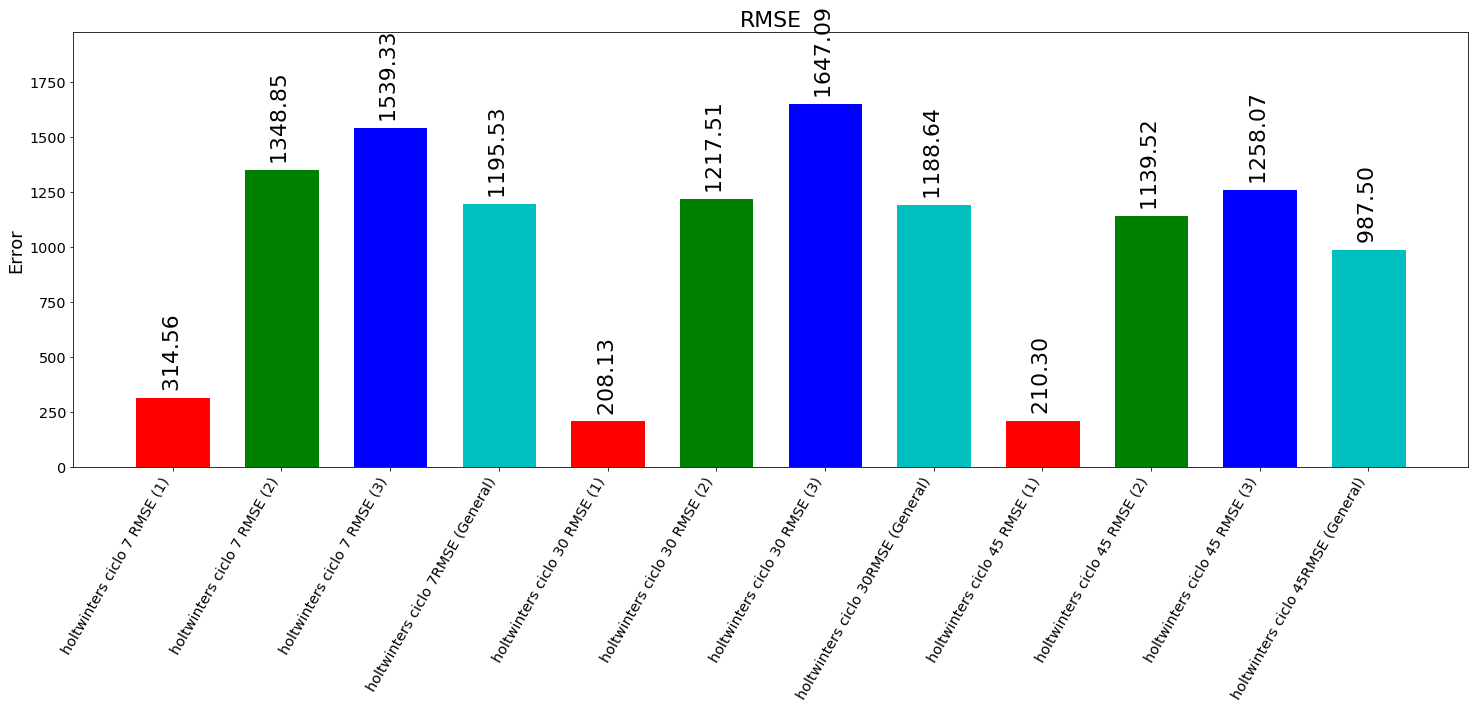

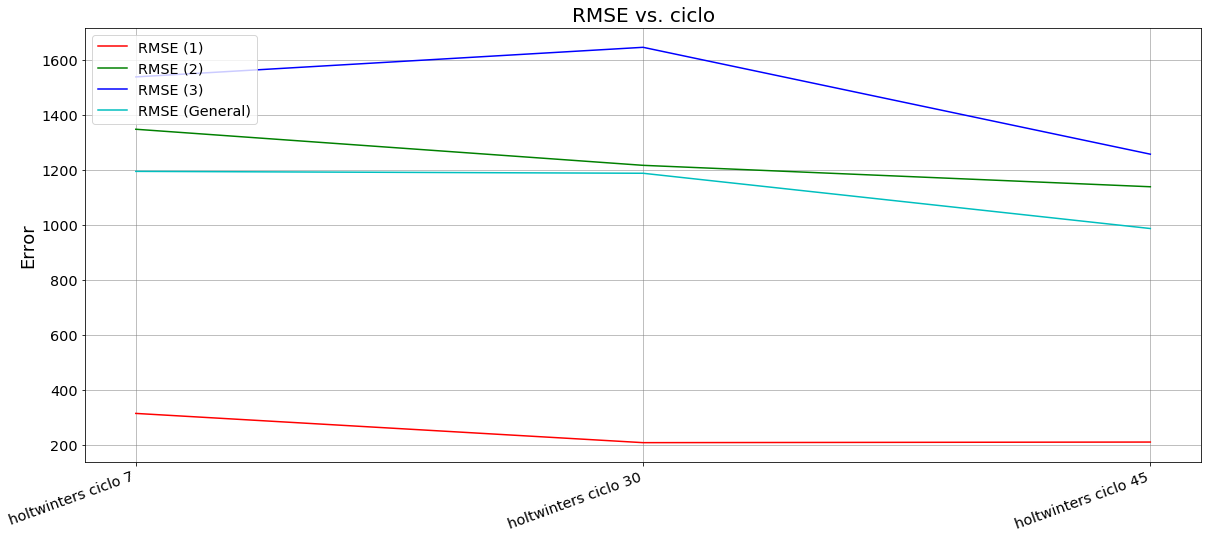

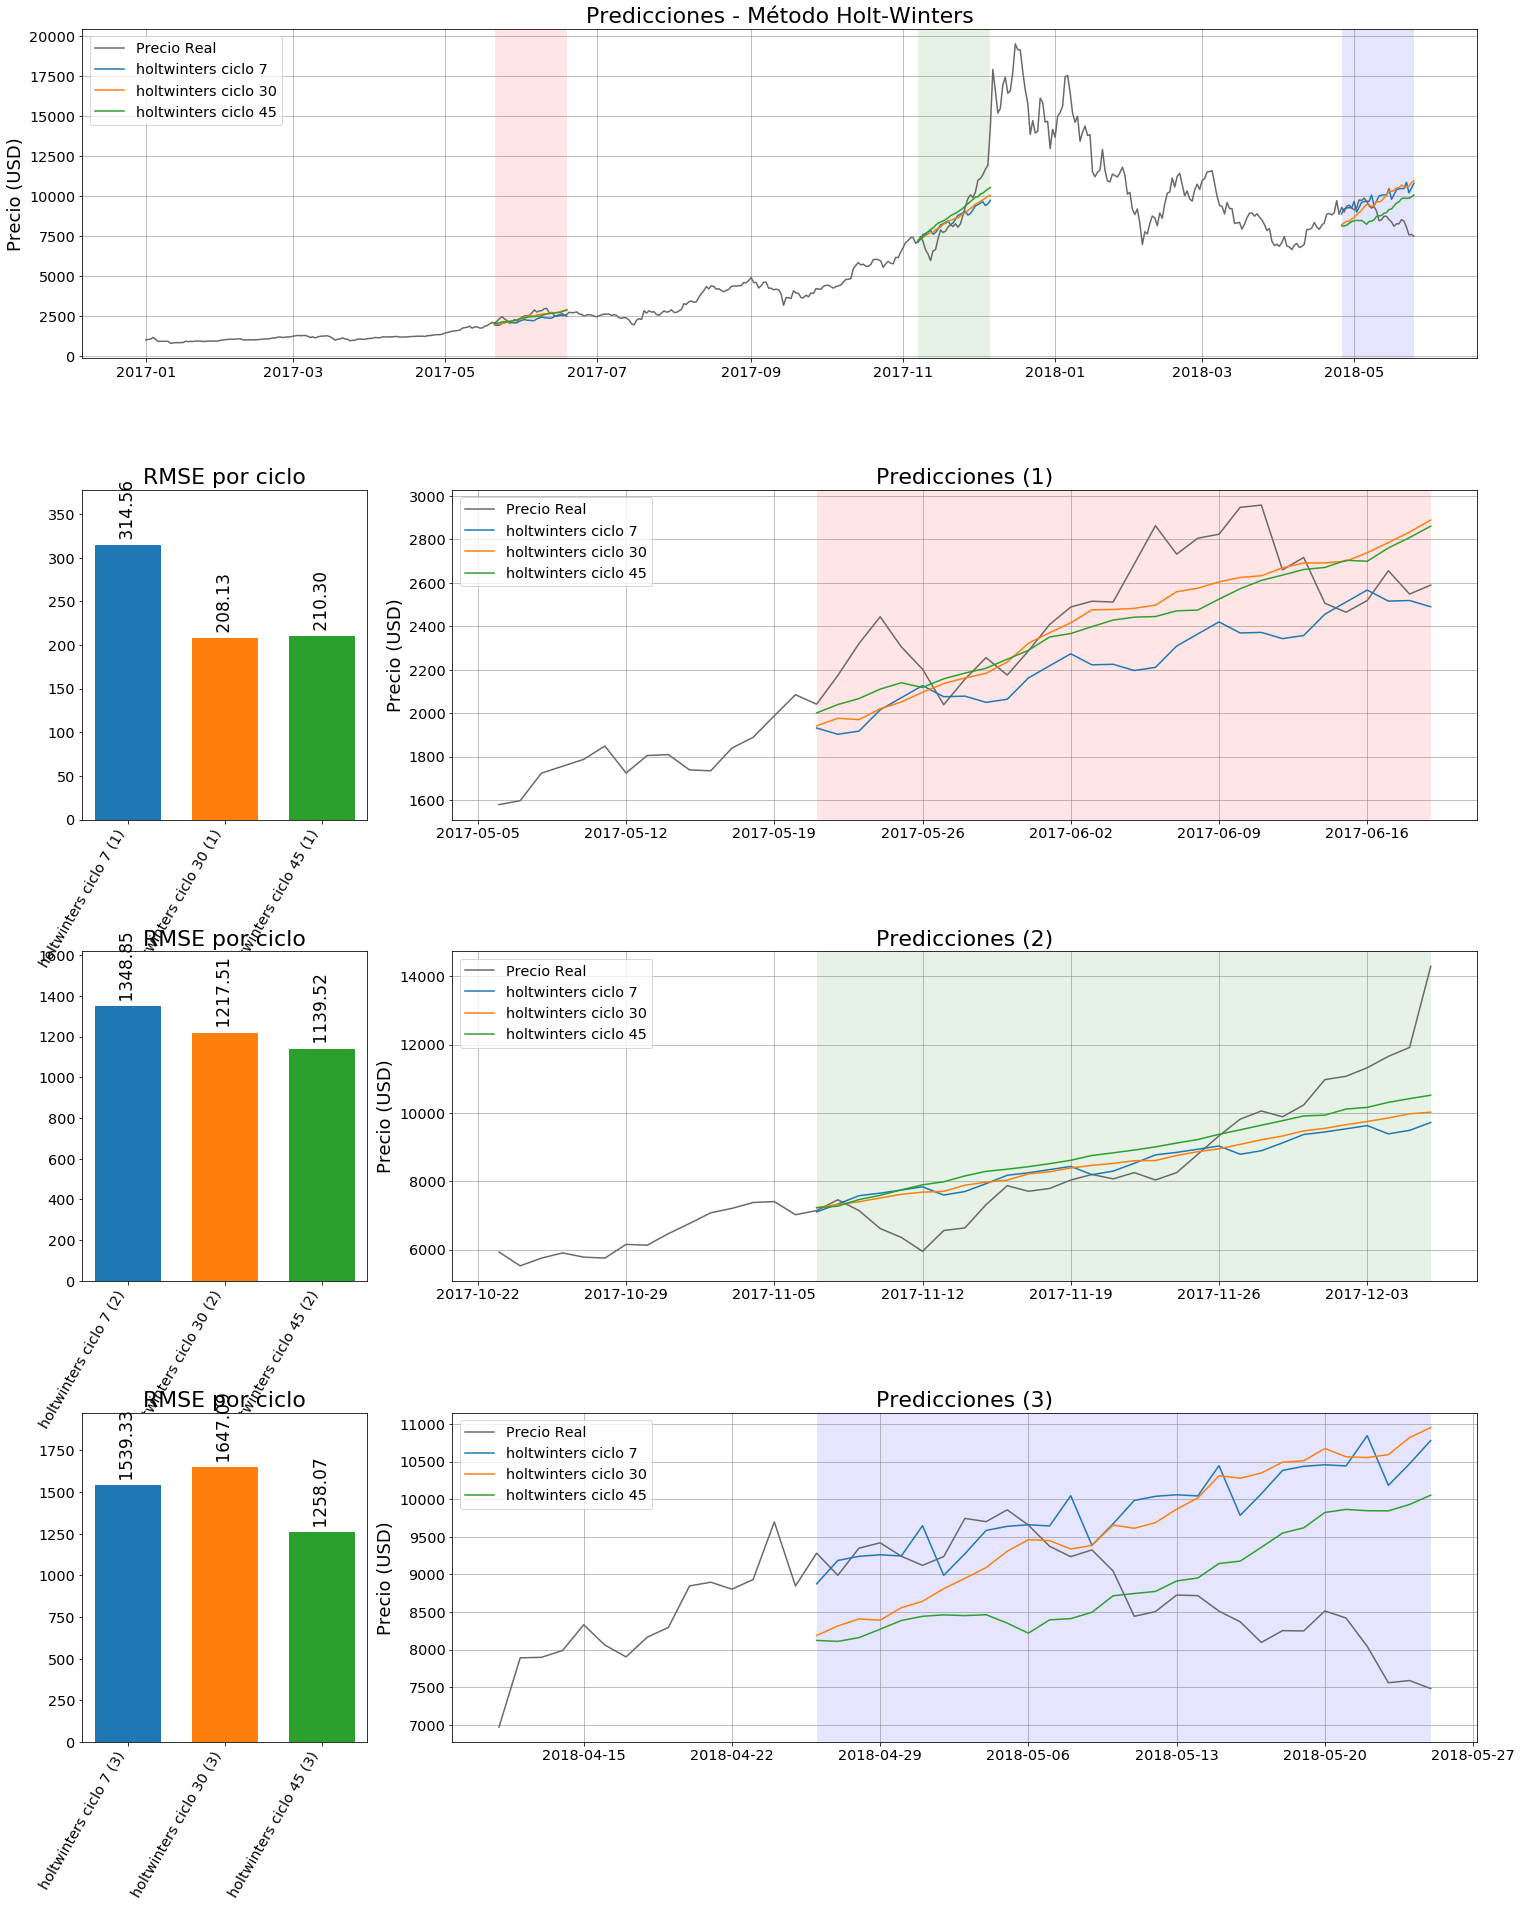

In [35]:
# HOLT WINTERS
prediccion_HWAD = pd.read_csv('baselines/HoltWinters_ad_fijo.csv')
prediccion_HWAD['Date'] = pd.to_datetime(prediccion_HWAD['Date'])
prediccion_HWAD.set_index('Date', inplace=True)

dataframe_rmse_HWAD = postprocesamiento(prediccion_HWAD, name='Holt-Winters', name_parametro='ciclo')
graficarBaselines(prediccion_HWAD,'Holt-Winters', 'ciclo')

In [ ]:
/* PARA ARREGLAR */

# Mostrar los mejores resultados para cada dia futuro
archivos = ['SES_02','SES_06','SES_09','Holt_lineal','Holt_exp','ARIMA']
N_tests=3
todaspredicciones = data.copy()[[moneda]]
rmses = [[] for i in range(0,len(futuro))]
for archivo in archivos:
    prediccion = pd.read_csv('baselines/'+ archivo +'.csv')
    prediccion['Date'] = pd.to_datetime(prediccion['Date'])
    prediccion.set_index('Date', inplace=True)
    
    #Obtengo un dataframe con las predicciones de un método para todos los días y todos los subconjuntos de tests
    prediccion_solotests = pd.DataFrame()
    for n_test in range(0,N_tests): 
        end = int((n_test+1)*len(prediccion)/N_tests)
        subprediccion = prediccion[0:end]
        subprediccion_test = subprediccion[-test_size:]
        
        prediccion_solotests = prediccion_solotests.append(subprediccion_test)
    todaspredicciones = pd.merge(todaspredicciones,prediccion_solotests.drop(columns=[moneda]), how="left",left_index=True,right_index=True)
    
    # Calculo los RMSE para cada día (toma los tres subconjuntos de tests al mismo tiempo)
    for i in range(1,len(prediccion_solotests.columns)):
        rmse = sqrt(mean_squared_error(prediccion_solotests[prediccion_solotests.columns[0]], 
                                       prediccion_solotests[prediccion_solotests.columns[i]]))
        rmses[i-1].append([prediccion_solotests.columns[i],rmse])

def getKey(rmse):
    return rmse[1]

top_columns = [moneda]

#Visualización de resultados
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 2, wspace=0.1, hspace=0.5)
for i in range(0,len(futuro)):
    top_rmses = sorted(rmses[i], key=getKey)
    rmses_x = [rmse[0] for rmse in top_rmses]
    rmses_y = [rmse[1] for rmse in top_rmses]

    top_columns.append(rmses_x[0])
    
    width = 1/1.5
    barplot = plt.subplot(gs[i])
    bars = plt.bar(rmses_x, rmses_y, width)
    for rect in bars: # Valores en las barras
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=15, ha='center',va='bottom',rotation=-20)
            rect.set_color(colores_futuro[i])
    plt.xticks(rotation=20, ha='right', fontsize=15)
    plt.title("RMSE día "+ str(futuro[i]),fontsize=20)
    plt.savefig("baselines/rmses.png", bbox_inches='tight')

graficarBaselines(todaspredicciones.filter(top_columns),"Top")